In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import random
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
import scipy
from torch import nn, optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms.functional as TF
from scipy.ndimage import distance_transform_edt as distance
from skimage import segmentation as skimage_seg
#from sampler import BalancedBatchSampler

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

#sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

#rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device =torch.device("cpu")
device

device(type='cuda')

# **Tissue heterogeneity**

In [ ]:
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
def calculate_heterogeneity(image, mask):
    # Extract the non-zero pixels within the tumor region
    tumor_pixels = image[mask == 1]
    nonzero_pixels = tumor_pixels[tumor_pixels!=0]
    heterogeneity = np.std(nonzero_pixels)

    return heterogeneity

# **Lesion Boundary Feature**

In [ ]:
import cv2
import numpy as np

def calculate_lbd(image, mask):
    # Convert the image to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the contours of the tumor region
    #contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #mask = mask.astype(np.uint8)

    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    #print(boundary)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))

    #coords_list = (np.array(coords_list)).reshape(10,1,2)

    # Select the points inside and outside the tumor region at a maximum distance of 5 pixels from the tumor boundary
    inside_band = []
    outside_band = []
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x, y] > 0:
                # Check the distance to the nearest contour point
                distances = scipy.spatial.distance.cdist(coords_list, [(x,y)], metric='euclidean')
                min_distance = np.min(distances)
                if min_distance !=0 and min_distance <= 3:
                  inside_band.append((x, y))
            else:
                # Check the distance to the nearest contour point

                distances = scipy.spatial.distance.cdist(coords_list, [(x,y)], metric='euclidean')
                min_distance = np.min(distances)
                if min_distance !=0 and min_distance <= 3:
                  outside_band.append((x, y))

    # Select the pixels inside and outside the tumor region
    # print(inside_band)
    inside_mask = np.zeros_like(mask)
    outside_mask = np.zeros_like(mask)
    for point in inside_band:
        inside_mask[point[0], point[1]] = 1
    for point in outside_band:
        outside_mask[point[0], point[1]] = 1
    # print(inside_mask)
    # print(outside_mask)
    # Calculate the average intensity of the inside and outside bands
    outside_mean = np.mean(image[outside_mask > 0])
    inside_mean = np.mean(image[inside_mask > 0])

    # Calculate the lesion boundary feature (LBd)
    lbd = abs(outside_mean- inside_mean)

    return lbd


# **Cocontrast**

In [ ]:
import cv2
import numpy as np

def calculate_contrast(C):
    # Calculate the size of the co-occurrence matrix
    m, n = C.shape

    # Create a matrix of row indices
    A1 = np.arange(1, m+1).reshape(-1, 1) * np.ones((1, n))

    # Create a matrix of column indices
    A2 = np.ones((m, 1)) * np.arange(1, n+1)

    # Calculate the difference between the row and column indices
    B = (A1 - A2)**2

    # Calculate the contrast
    CC = np.sum(B * C)

    return CC

def calculate_cocontrast(image, mask, num_levels, displacement):
    # Create the co-occurrence matrix

    cooccurrence_matrix = np.zeros((num_levels, num_levels))
    N=0
    # Iterate over the pixels in the image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]-1):
            #print(mask[y, x].shape)
            # Only calculate the co-occurrence value if the pixel is within the tumor region
            if mask[y, x] == 1:
                value = image[y, x]
                neighbor_value = image[y + displacement[1], x + displacement[0]]
                cooccurrence_matrix[value, neighbor_value] += 1
                N = N+1
    # Normalize the co-occurrence matrix
    cooccurrence_matrix /= N
    cocontrast = calculate_contrast(cooccurrence_matrix)
    #print(cocontrast)

    return cocontrast


# **Shape Asymmetry factor**

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from skimage import data, segmentation as skimage_seg
from scipy.spatial.distance import cdist
from skimage.measure import EllipseModel
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def calculate_saf(mask):
    boundaries = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    #print(boundaries)
    coords = np.where(boundaries == 1)
    #print(coords)
    coords_list = list(zip(coords[0], coords[1]))
    N=len(coords_list)+150
    coords_list = (np.array(coords_list))
    clockwise_boundary_points = sort_coordinates(coords_list)
    ellipse = cv2.fitEllipse(clockwise_boundary_points)
    x0, y0 = ellipse[0]
    a, b = ellipse[1]
    theta = ((ellipse[2])*np.pi)/180
    a=a/2
    b=b/2
    t = np.linspace(0, 2*np.pi, N)
    x = x0 + a * np.cos(theta) * np.cos(t) - b * np.sin(theta) * np.sin(t)
    y = y0 + a * np.sin(theta) * np.cos(t) + b * np.cos(theta) * np.sin(t)
    ellipse_points = list(set(zip(x,y)))
    points = (np.array(ellipse_points))
    distance_sum=0
    for p in coords_list:
        distances = cdist(points,[p])
        min_distance = np.min(distances)
        #print(min_distance)
        distance_sum = distance_sum+ min_distance

    mask =(mask/255).astype(np.uint8)

    clockwise_boundary_points = sort_coordinates(coords_list)
    area = cv2.contourArea(clockwise_boundary_points)
    saf = distance_sum /(area)
    return saf

# **Form_factor**

In [ ]:
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def get_formfactor(mask):
    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))
    boundary_points = np.array(coords_list)
    clockwise_boundary_points = sort_coordinates(boundary_points)


    # Get the perimeter of the mask
    mask_perimeter= cv2.arcLength(clockwise_boundary_points, True)
    mask_area = cv2.contourArea(clockwise_boundary_points)
    #print(mask_perimeter)

    # Compute the convexity
    formfactor = (4*3.1416*mask_area) / (mask_perimeter**2)

    return formfactor

# **Shape_factor**

In [ ]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
from skimage import data, segmentation as skimage_seg
from scipy.spatial.distance import cdist
from skimage.measure import EllipseModel
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def calculate_shapefactor(mask):
    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))
    boundary_points = np.array(coords_list)
    clockwise_boundary_points = sort_coordinates(boundary_points)

    # clockwise_boundary_points = sort_coordinates(boundary_points)
    #print(clockwise_boundary_points)
    N = len(coords_list)+20

    ellipse = cv2.fitEllipse(clockwise_boundary_points)
    x0, y0 = ellipse[0]
    a, b = ellipse[1]
    theta = ((ellipse[2])*np.pi)/180
    a=a/2
    b=b/2
    t = np.linspace(0, 2*np.pi, N)
    x = x0 + a * np.cos(theta) * np.cos(t) - b * np.sin(theta) * np.sin(t)
    y = y0 + a * np.sin(theta) * np.cos(t) + b * np.cos(theta) * np.sin(t)
    # x = np.rint(x).astype(np.uint8)
    # y = np.rint(y).astype(np.uint8)
    ellipse_points = list(set(zip(x,y)))
    ellipse_points = (np.array(ellipse_points,dtype=np.float32))
    clockwise_ellipse_points = sort_coordinates(ellipse_points)
    #print(clockwise_ellipse_points)


    actual_perimeter = cv2.arcLength(clockwise_boundary_points, True)
    elliptical_perimeter = cv2.arcLength(clockwise_ellipse_points, True)

    shf= elliptical_perimeter/actual_perimeter
    return shf



# **Margin_Definition**

In [ ]:
import numpy as np
from skimage.segmentation import find_boundaries
from skimage.filters import sobel

def margin_definition(image, mask):
    # Find boundary pixels
    boundaries = find_boundaries(mask, mode='inner').astype(np.uint8)
    #boundary_intensity_sum = np.sum(image[boundaries == 1])
    # Apply Sobel filter to the image
    sobel_x = sobel(image, axis=0, mode='constant')
    sobel_y = sobel(image, axis=1, mode='constant')

    # Calculate gradient magnitude on the boundary pixels
    gradient_magnitude = np.sqrt(sobel_x[boundaries == 1] ** 2 + sobel_y[boundaries == 1] ** 2)

    # Calculate sum of intensity values of boundary pixels in the original image
    boundary_intensity_sum = np.sum(image[boundaries == 1])

    # Calculate margin definition
    margin_definition = np.sum(gradient_magnitude) / boundary_intensity_sum

    return margin_definition



# **Posterior_Acoustic_Feature**

In [ ]:
import numpy as np
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def posterior_acoustic_feature(image, mask):
    # Find properties of the tumor region
    #mask = mask/255
    boundaries = find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundaries == 1)
    coords_list = list(zip(coords[0], coords[1]))
    coords_list = (np.array(coords_list))
    clockwise_boundary_points = sort_coordinates(coords_list)

    x,y,h,w = cv2.boundingRect(clockwise_boundary_points)
    # print(x,y,w,h)
    width= round((2/3)*w)
    height= min(50,h)
    # Define the coordinates of the rectangle
    rect_coords = (x+h, y, x+h+height, y+width)
    rect_region = image[rect_coords[0]:rect_coords[2], rect_coords[1]:rect_coords[3]]
    # Calculate the average intensity of the tumor region
    tumor_mean = np.mean(image[mask == 1])

    # Calculate the average intensity of the rectangular region
    rect_mean = np.mean(rect_region)
    # print(rect_mean)

    # Calculate the posterior acoustic feature
    posterior_acoustic_feature = (rect_mean - tumor_mean)

    return posterior_acoustic_feature


# **Convexity**

In [ ]:
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def get_convexity(mask):
    # Get the (x, y) coordinates of the non-zero pixels
    # x, y = np.where(mask)
    # mask_points = np.array([x, y]).T
    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))
    boundary_points = np.array(coords_list)
    clockwise_boundary_points = sort_coordinates(boundary_points)


    # Find the convex hull of the mask
    convex_hull = cv2.convexHull(clockwise_boundary_points,clockwise=True)

    # Get the perimeter of the convex hull
    convex_perimeter = cv2.arcLength(convex_hull, True)


    # Get the perimeter of the mask
    mask_perimeter = cv2.arcLength(clockwise_boundary_points, True)
    #print(mask_perimeter)

    # Compute the convexity
    convexity = convex_perimeter / mask_perimeter

    return convexity



# **SemiminorAxis**

In [ ]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
from skimage import data, segmentation as skimage_seg
from scipy.spatial.distance import cdist
from skimage.measure import EllipseModel
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def calculate_semiminoraxis(mask):
    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))
    boundary_points = np.array(coords_list)
    clockwise_boundary_points = sort_coordinates(boundary_points)
    #print(clockwise_boundary_points)
    N = len(coords_list)+20

    ellipse = cv2.fitEllipse(clockwise_boundary_points)
    x0, y0 = ellipse[0]
    a, b = ellipse[1]
    theta = ((ellipse[2])*np.pi)/180


    return a

# **Orientation Angle**

In [ ]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
from skimage import data, segmentation as skimage_seg
from scipy.spatial.distance import cdist
from skimage.measure import EllipseModel
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(90+angles)
    return list_of_xy_coords[indices]

def calculate_ellipseangle(mask):
    boundary = skimage_seg.find_boundaries(mask, mode='inner').astype(np.uint8)
    coords = np.where(boundary == 1)
    coords_list = list(zip(coords[0], coords[1]))
    boundary_points = np.array(coords_list)
    clockwise_boundary_points = sort_coordinates(boundary_points)
    #print(clockwise_boundary_points)
    N = len(coords_list)+20

    ellipse = cv2.fitEllipse(clockwise_boundary_points)
    x0, y0 = ellipse[0]
    a, b = ellipse[1]
    #print(ellipse[2])
    if ellipse[2]>90:
       theta = 180-ellipse[2]
       theta = (theta*np.pi)/180
    else:
       theta = (ellipse[2]*np.pi)/180


    return theta


# **Dataset Name**

In [ ]:
dataset= 'Combined_Final'
method= 'Feature_CBAM_Add'

# **QUS Feature Calculation for all images in the dataset**

In [ ]:
folders = ['Fold11/test', 'Fold22/test', 'Fold33/test', 'Fold44/test', 'Fold55/test']
folds=[1,2,3,4,5]
def quantitative_ultrasound_features(image, mask):

    hetgn = calculate_heterogeneity(image, mask)
    saf = calculate_saf(mask)
    ff = get_formfactor(mask)
    sf = calculate_shapefactor(mask)
    md = margin_definition(image, mask)
    paf = posterior_acoustic_feature(image, mask)
    convexity = get_convexity(mask)
    sma = calculate_semiminoraxis(mask)
    oa = calculate_ellipseangle(mask)
    features= [hetgn, saf, ff, sf, md, paf, convexity, oa]
    return features

png_files = []
for folder in folders :
    for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/{folder}'):
        for file in files:
            png_files.append(os.path.join(subdir, file))

augmented_files_gt1 = []
for fold in folds:
    for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train/malignant'):
            for file in files:
                if file.startswith('augmented') or file.startswith('augmented2') or file.startswith('augmented3'):
                    augmented_files_gt1.append(os.path.join(subdir, file))

for fold in folds:
    for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train/benign'):
            for file in files:
                if file.startswith('augmented') or file.startswith('augmented2') or file.startswith('augmented3'):
                    augmented_files_gt1.append(os.path.join(subdir, file))

all_image_files = augmented_files_gt1+png_files
df = pd.DataFrame({'Image_path': all_image_files})
df['Image_path'] = df['Image_path'].apply(lambda x: x.replace("\\", "/"))
df['Mask_path'] =   df['Image_path'].apply(lambda x: x.replace('Fold11/train/malignant','all_masks').replace('Fold11/train/benign','all_masks').
                                           replace('Fold22/train/malignant','all_masks').replace('Fold22/train/benign','all_masks').
                                           replace('Fold33/train/malignant','all_masks').replace('Fold33/train/benign','all_masks').
                                           replace('Fold44/train/malignant','all_masks').replace('Fold44/train/benign','all_masks').
                                           replace('Fold55/train/malignant','all_masks').replace('Fold55/train/benign','all_masks').
                                           replace('Fold11/test/benign','all_masks').replace('Fold11/test/malignant','all_masks').
                                           replace('Fold22/test/benign','all_masks').replace('Fold22/test/malignant','all_masks').
                                           replace('Fold55/test/malignant','all_masks').replace('Fold55/test/benign','all_masks').
                                           replace('Fold33/test/benign','all_masks').replace('Fold33/test/malignant','all_masks').
                                           replace('Fold44/test/benign','all_masks').replace('Fold44/test/malignant','all_masks').
                                           replace('.png','_mask.png').replace('.bmp','_mask.bmp').replace('.jpg','_mask.jpg'))

df['Mask_path'] = df['Mask_path'].apply(lambda x: x.replace('_mask.png','.png') if (x.split('/')[-1].startswith('000')) else x)
df['Mask_path'] = df['Mask_path'].apply(lambda x: x.replace('_mask.bmp','.bmp') if (x.split('/')[-1].startswith('us')) else x)

# for fold in folds:
#     df['Mask_path'] = df['Image_path'].apply(lambda x: x.replace(f'Fold{fold}{fold}/train/malignant','all_masks').replace(f'Fold{fold}{fold}/train/benign','all_masks')
#                                              .replace(f'Fold{fold}{fold}/test/malignant','all_masks').replace(f'Fold{fold}{fold}/test/benign','all_masks')
#                                              .replace('.png','_mask.png'))

for fold in folds:
    df['Mask_path'] = df['Mask_path'].apply(lambda x: x.replace('_mask.png','.png') if (((x.split('/')[-1].startswith(f'augmented_fold{fold}'))
                                             or (x.split('/')[-1].startswith(f'augmented2_fold{fold}'))
                                             or (x.split('/')[-1].startswith(f'augmented3_fold{fold}')))
                                             and x.split('/')[-1].split('_')[-2].startswith('000')) else x)

for fold in folds:
    df['Mask_path'] = df['Mask_path'].apply(lambda x: x.replace('_mask.bmp','.bmp') if (((x.split('/')[-1].startswith(f'augmented_fold{fold}')))
                                             and x.split('/')[-1].split('_')[-2].startswith('us')) else x)


# if df['Mask_path'].apply(lambda x: x.split('/')[-1]).startswith('000'):
#    df['Mask_path'] =   df['Mask_path'].apply(lambda x: x.replace('_mask.png','.png'))

all_features = []
import tqdm
mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

for i in tqdm.tqdm(range(len(df))):
    # print(df['Image_path'][i])
    # print(df['Mask_path'][i])
    inputs =  cv2.imread(df['Image_path'][i])
    inputs = cv2.resize(inputs,(299,299))/255
    inputs -= np.expand_dims(mean_nums, axis=(0, 1))
    inputs /= np.expand_dims(std_nums, axis=(0, 1))
    masks = cv2.imread(df['Mask_path'][i])
    masks = cv2.resize(masks, (299,299))
    masks[masks<200] = 0
    masks[masks>200] = 1
    features = quantitative_ultrasound_features(inputs[:,:,0], masks[:,:,0])
    all_features.append(features)
new_column = pd.DataFrame(all_features, columns=['{}'.format(i) for i in ['hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']])
df = pd.concat([df, new_column], axis=1)
df['Image_name'] = df['Image_path'].apply(lambda x: x.split('/')[-1])
df = df.set_index('Image_name')

In [ ]:
print(df['Mask_path'][i])
df[df.index.duplicated()]
df.to_excel('/content/drive/My Drive/Results/feature_combined_final.xlsx', index=True)
df

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Results/feature_combined_final.xlsx', sheet_name='Sheet1')

In [ ]:
df = df.set_index('Image_name')

In [ ]:
df

,Image_path,Mask_path,hetgn,saf,ff,sf,md,paf,convexity,oa
Image_name,,,,,,,,,,
augmented_fold1_1_malignant (83).png,/content/drive/My Drive/Combined_Final/Fold11/...,/content/drive/My Drive/Combined_Final/all_mas...,0.681537,0.384107,0.392697,0.698951,14.969496,0.010201,0.754350,0.627230
augmented_fold1_0_malignant (126).png,/content/drive/My Drive/Combined_Final/Fold11/...,/content/drive/My Drive/Combined_Final/all_mas...,0.796598,0.160491,0.587136,0.822964,0.297451,-0.372136,0.867948,0.321147
augmented_fold1_12_malignant (65).png,/content/drive/My Drive/Combined_Final/Fold11/...,/content/drive/My Drive/Combined_Final/all_mas...,0.494259,0.363581,0.241342,0.551987,-2.410618,0.760409,0.598667,1.150015
augmented_fold1_10_malignant (103).png,/content/drive/My Drive/Combined_Final/Fold11/...,/content/drive/My Drive/Combined_Final/all_mas...,1.356533,0.304679,0.034190,0.199951,0.297551,-1.226948,0.211733,1.414437
augmented_fold1_9_malignant (206).png,/content/drive/My Drive/Combined_Final/Fold11/...,/content/drive/My Drive/Combined_Final/all_mas...,0.634202,0.113927,0.663612,0.826882,0.912506,0.373440,0.859066,1.130474
...,...,...,...,...,...,...,...,...,...,...
14-17-42.bmp,/content/drive/My Drive/Combined_Final/Fold55/...,/content/drive/My Drive/Combined_Final/all_mas...,0.136343,0.455927,0.037419,0.215401,-0.111285,-0.016070,0.230280,1.334030
17-12-01.bmp,/content/drive/My Drive/Combined_Final/Fold55/...,/content/drive/My Drive/Combined_Final/all_mas...,0.404067,0.143534,0.613765,0.819082,-0.380946,0.698376,0.864200,0.084847
18-05-54.bmp,/content/drive/My Drive/Combined_Final/Fold55/...,/content/drive/My Drive/Combined_Final/all_mas...,0.417861,0.169502,0.170345,0.424621,-0.238792,0.147727,0.444440,1.186937


# **Feature Normalization for each fold with corresponding training images**

In [ ]:
fold = 1
fold1_train_files = []
for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'):
    for file in files:
        fold1_train_files.append(os.path.join(subdir, file))

print(len(fold1_train_files))
df_fold1 = pd.DataFrame({'Image_path': fold1_train_files})
df_fold1['Image_name'] = df_fold1['Image_path'].apply(lambda x: x.split('/')[-1])
df_fold1 = df_fold1.set_index('Image_name')
df_fold1[['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']] = df.loc[df_fold1.index, ['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']]


columns_to_normalize = df.columns[2:10]  # Select columns 2 to 10 (assuming you want to include column 10)

for column in columns_to_normalize:
    values = df_fold1[column].values
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    df_fold1[column] = normalized_values


1548


In [ ]:
fold = 2
fold2_train_files = []
for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'):
    for file in files:
        fold2_train_files.append(os.path.join(subdir, file))

print(len(fold2_train_files))
df_fold2 = pd.DataFrame({'Image_path': fold2_train_files})
df_fold2['Image_name'] = df_fold2['Image_path'].apply(lambda x: x.split('/')[-1])
df_fold2 = df_fold2.set_index('Image_name')
df_fold2[['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']] = df.loc[df_fold2.index, ['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']]


columns_to_normalize = df.columns[2:10]  # Select columns 2 to 10 (assuming you want to include column 10)

for column in columns_to_normalize:
    values = df_fold2[column].values
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    df_fold2[column] = normalized_values

1549


In [ ]:
fold = 3
fold3_train_files = []
for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'):
    for file in files:
        fold3_train_files.append(os.path.join(subdir, file))

print(len(fold3_train_files))
df_fold3 = pd.DataFrame({'Image_path': fold3_train_files})
df_fold3['Image_name'] = df_fold3['Image_path'].apply(lambda x: x.split('/')[-1])
df_fold3 = df_fold3.set_index('Image_name')
df_fold3[['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']] = df.loc[df_fold3.index, ['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']]



columns_to_normalize = df.columns[2:10]  # Select columns 2 to 10 (assuming you want to include column 10)

for column in columns_to_normalize:
    values = df_fold3[column].values
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    df_fold3[column] = normalized_values

1548


In [ ]:
fold = 4
fold4_train_files = []
for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'):
    for file in files:
        fold4_train_files.append(os.path.join(subdir, file))

print(len(fold4_train_files))
df_fold4 = pd.DataFrame({'Image_path': fold4_train_files})
df_fold4['Image_name'] = df_fold4['Image_path'].apply(lambda x: x.split('/')[-1])
df_fold4 = df_fold4.set_index('Image_name')
df_fold4[['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']] = df.loc[df_fold4.index, ['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']]


columns_to_normalize = df.columns[2:10]  # Select columns 2 to 10 (assuming you want to include column 10)

for column in columns_to_normalize:
    values = df_fold4[column].values
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    df_fold4[column] = normalized_values

1549


In [ ]:
fold = 5
fold5_train_files = []
for subdir, dirs, files in os.walk(f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'):
    for file in files:
        fold5_train_files.append(os.path.join(subdir, file))

print(len(fold5_train_files))
df_fold5 = pd.DataFrame({'Image_path': fold5_train_files})
df_fold5['Image_name'] = df_fold5['Image_path'].apply(lambda x: x.split('/')[-1])
df_fold5 = df_fold5.set_index('Image_name')
df_fold5[['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']] = df.loc[df_fold5.index, ['Mask_path', 'hetgn', 'saf', 'ff', 'sf', 'md', 'paf', 'convexity', 'oa']]


columns_to_normalize = df.columns[2:10]  # Select columns 2 to 10 (assuming you want to include column 10)

for column in columns_to_normalize:
    values = df_fold5[column].values
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    df_fold5[column] = normalized_values

1549


# **Dataset**

In [ ]:

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

transforms_dict = {'train': T.Compose([
  T.Resize([299,299]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'validation': T.Compose([
  T.Resize([299,299]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize([299,299]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
'mask': T.Compose([
  T.Resize([299,299]),
  T.ToTensor()
])
}
class MyDataset(Dataset):
    def __init__(self, img_list,us_features=None, train =False,  mask_path = None,transforms = None):
        self.img_list = img_list
        self.mask_path = mask_path
        self.transforms = transforms
        self.train = train
        self.us_features = us_features

    def dist(self, image, mask):

        gt = mask.numpy()
        gt = gt.astype(np.uint8)
        posmask = gt
        negmask = 1-posmask
        posdis = distance(posmask)
        negdis = distance(negmask)
        boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
        sdf = (negdis-np.min(negdis))/(np.max(negdis)-np.min(negdis)) - (posdis-np.min(posdis))/(np.max(posdis)-np.min(posdis))

        return sdf

    def transform2(self, image, mask):
        # Resize

        # Random rotate
        if random.random() > 0.5:
            angle = 5 #random.randint(5,15)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        # if random.random() > 0.5:
        #     image = TF.vflip(image)
        #     mask = TF.vflip(mask)


        return image, mask


    def get_label(self) :
        labels = []
        for i in self.img_list :
            if i.split('/')[-2] == 'benign' :
                labels.append(0)

            elif i.split('/')[-2] == 'malignant' :
                 labels.append(1)
        return torch.tensor(labels)



    def __getitem__(self, index):

        img_path= self.img_list[index]
        # print(img_path)
        # print(img_path.split('/')[-1])

        inputs = Image.open(img_path)

        if  img_path.split('.')[-1] == 'bmp' :
            inputs = inputs.convert("RGB")
        elif (img_path.split('/')[-1].startswith(f'augmented_fold{fold}') or img_path.split('/')[-1].startswith(f'augmented2_fold{fold}') or img_path.split('/')[-1].startswith(f'augmented3_fold{fold}')):
            if img_path.split('/')[-1].split('_')[-1].startswith('000'):
               inputs = inputs.convert("RGB")
        elif img_path.split('/')[-1].startswith('000'):
            inputs = inputs.convert("RGB")
        elif img_path.split('/')[-1].startswith('Case'):
            inputs = inputs.convert("RGB")
        #inputs = Image.merge("RGB", (inputs, inputs, inputs))

        if self.us_features is not None:


            image_name = img_path.split('/')[-1]

            us_feature = self.us_features.loc[image_name][2:].values

            us_feature = us_feature.astype(float)

        if self.mask_path:
          if img_path.split('.')[-1] == 'png' :
            if img_path.split('/')[-1].split('_')[-1].startswith('000') :
                mask_path = os.path.join(self.mask_path,img_path.split('/')[-1].split('.')[0]+'.png')

            else :
                mask_path = os.path.join(self.mask_path,img_path.split('/')[-1].split('.')[0]+'_mask.png')

          elif  img_path.split('.')[-1] == 'bmp' :
            if img_path.split('/')[-1].split('_')[-1].startswith('us'):
               mask_path = os.path.join(self.mask_path,img_path.split('/')[-1].split('.')[0]+'.bmp')
            else:
               mask_path = os.path.join(self.mask_path,img_path.split('/')[-1].split('.')[0]+'_mask.bmp')

          elif img_path.split('.')[-1] == 'jpg' :
               mask_path = os.path.join(self.mask_path,img_path.split('/')[-1].split('.')[0]+'_mask.jpg')

          masks = Image.open(mask_path)

        if img_path.split('/')[-2] == 'benign' :
            label = 0
        elif img_path.split('/')[-2] == 'malignant' :
            label = 1

        else :
            assert  "Invalid Path" # denominator can't be 0

        if self.transforms :
            inputs = self.transforms[0] (inputs)
            if self.mask_path:
                masks  =  self.transforms[1] (masks)
        if self.mask_path and self.train:
            inputs,masks = self.transform2(inputs, masks)
            dist_map = self.dist(inputs, masks)

        if self.train:
            if self.us_features is not None:
               return inputs,label,masks,dist_map,us_feature
            if self.mask_path is not None:
               return inputs,label,masks,dist_map
            else:
               return inputs, label

        else :
            if self.mask_path:
                return inputs,label,masks
            else :
                return inputs,label

    def __len__(self):
        return len(self.img_list)



In [ ]:
import os
def get_list_train_val(fold):
    train_dir =f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/train'
    validation_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/validation'

    train_mask = f'/content/drive/My Drive/{dataset}/all_masks'

    def get_list_of_data (dir_):
        data_list = list()
        dir_sub = [os.path.join(dir_,i).replace('\\','/') for i in os.listdir(dir_)]
        for i in dir_sub:
            list_ = [os.path.join(i,j).replace('\\','/') for j in os.listdir(i)]
            data_list += list_
        return data_list

    train_list_img = get_list_of_data(train_dir)
    val_list_img = get_list_of_data(validation_dir)

    return train_list_img, val_list_img, train_mask

def get_list_test(fold):

    test_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}/test'
    test_mask = f'/content/drive/My Drive/{dataset}/all_masks'

    def get_list_of_data (dir_):
        data_list = list()
        dir_sub = [os.path.join(dir_,i).replace('\\','/') for i in os.listdir(dir_)]
        for i in dir_sub:
            list_ = [os.path.join(i,j).replace('\\','/') for j in os.listdir(i)]
            data_list += list_
        return data_list

    test_list_img = get_list_of_data(test_dir)


    return test_list_img, test_mask


In [ ]:
class_names = ['benign', 'malignant']

In [ ]:
def imshow(inp, title=None):

  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  #print(inp[0,:,:]==inp[1,:,:])
  inp = np.clip(inp, 0, 1)
  plt.figure(figsize = (15,6))
  plt.imshow(inp, cmap='gray')
  if title is not None:
    plt.title(title)
  plt.axis('off')

def imshow2(inp, title=None):
  print(torch.max(inp))
  inp = inp.numpy().transpose((1, 2, 0))
  plt.figure(figsize = (15,6))
  #inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')





In [ ]:
writer = SummaryWriter(f'runs/inception_cam_feature_SEB_Respreprocessor_{dataset}_CBAM_Add')

# Write image data to TensorBoard log dir



# Model

In [ ]:
class SEBlock(nn.Module):

    def __init__(self, n_features, reduction=8):
        super(SEBlock, self).__init__()

        if n_features % reduction != 0:
            raise ValueError('n_features must be divisible by reduction (default = 16)')

        self.linear1 = nn.Linear(n_features, n_features // reduction, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(n_features // reduction, n_features, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):

        y = self.avg_pool(x)
        y = y.permute(0, 2, 3, 1)
        y = self.relu(self.linear1(y))
        y = self.sigmoid(self.linear2(y))
        y = y.permute(0, 3, 1, 2)
        y = x * y
        return y

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self,kernel_size=1):
        super().__init__()
        self.conv=nn.Conv2d(2,1,kernel_size=kernel_size, padding='same')
        self.sigmoid=nn.Sigmoid()

    def forward(self, x) :
        max_result,_=torch.max(x,dim=1,keepdim=True)
        avg_result=torch.mean(x,dim=1,keepdim=True)
        result=torch.cat([max_result,avg_result],1)
        output=self.conv(result)
        output=self.sigmoid(output)
        x = output*x
        return x

In [ ]:
class prep_model(nn.Module):
    def __init__(self, dropout= False, channel_attention= True, spatial_attention= True,add_sub= True):
        super().__init__()
        self.conv1 = nn.Conv2d(3,192,1)
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.aux_logits=False
        self.conv2 = nn.Conv2d(64,1,1)
        self.drop= dropout
        self.channel_attention= channel_attention
        self.spatial_attention= spatial_attention
        self.addsub= add_sub

        self.dropout= torch.nn.Dropout2d(p=0.5, inplace=False)
        self.seb = SEBlock(64)
        self.sp = SpatialAttention(7)

    def forward(self, x):
        identity = x[:,2:3,:,:]
        b,c,h,w = x.shape

        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.maxpool(x)

        #layer1
        x = self.resnet.layer1[0].conv1(x)
        x = self.resnet.layer1[0].bn1(x)
        x = self.resnet.layer1[0].conv2(x)
        x = self.resnet.layer1[0].bn2(x)
        x = self.resnet.layer1[1].conv1(x)
        x = self.resnet.layer1[1].bn1(x)
        x = self.resnet.layer1[1].conv2(x)
        x = self.resnet.layer1[1].bn2(x)

        if self.drop==True:
           x = self.dropout(x)

        if self.spatial_attention==True:
           spa = self.sp(x)
           x = x+spa
           #print(x.shape)

        if self.channel_attention==True:
           x = self.seb(x)

        x = F.interpolate(self.conv2(x),(h,w))


        if self.addsub==True:
           x = identity+x




        return x

In [ ]:
prep= prep_model().to(device)
prep

In [ ]:
class my_model(nn.Module):
    # for input size 224
    def __init__(self):
        super(my_model, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        self.inception.aux_logits=False
        n_features = self.inception.fc.in_features
        self.seb= SEBlock(2048)
        self.inception.fc = nn.Linear(n_features, 2)
        self.preprocessor= prep_model()
        self.mean=torch.Tensor([0.275]).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
        self.std= torch.Tensor([0.197]).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
        #self.avgpool= nn.AdaptiveAvgPool2d((1, 1))
        self.fc1= nn.Linear(2048,64)
        self.fc2= nn.Linear(64,8)

        self.fc3= nn.Linear(2048,64)
        self.fc4= nn.Linear(64,8)

        self.fc5= nn.Linear(2048,64)
        self.fc6= nn.Linear(64,8)

        self.fc7= nn.Linear(2048,64)
        self.fc8= nn.Linear(64,8)

        self.fc9= nn.Linear(2048,64)
        self.fc10= nn.Linear(64,8)

        self.fc11= nn.Linear(2048,64)
        self.fc12= nn.Linear(64,8)

        self.fc13= nn.Linear(2048,64)
        self.fc14= nn.Linear(64,8)

        self.fc15= nn.Linear(2048,64)
        self.fc16= nn.Linear(64,8)

        #self.attention_gate = attention_gate(x,g)
        #self.inception.load_state_dict(torch.load('/content/drive/My Drive/Results/Weight/incep.bin'))


    def forward(self, x):
        prep = self.preprocessor(x)
        prep = (prep-self.mean)/self.std
        prep_out = torch.cat([x[:,0:2,:,:],prep],1)
        x = self.inception.Conv2d_1a_3x3(prep_out)
        # N x 32 x 149 x 149
        x = self.inception.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.inception.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.inception.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.inception.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.inception.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.inception.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.inception.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.inception.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.inception.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.inception.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.inception.Mixed_6e(x)
        # N x 768 x 17 x 17
        # N x 768 x 17 x 17
        x = self.inception.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.inception.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.inception.Mixed_7c(x)
        p = self.seb(x)



        # N x 2048 x 8 x 8
        # Adaptive average pooling

        x = self.inception.avgpool(p)
        gap = x.view(x.size(0), -1)

        # N x 2048 x 1 x 1
        x = self.inception.dropout(gap)
        x = self.inception.fc(x)

        y1 = torch.sigmoid(self.fc2(self.fc1(gap)))
        y2 = torch.sigmoid(self.fc4(self.fc3(gap)))
        y3 = torch.sigmoid(self.fc6(self.fc5(gap)))
        y4 = torch.sigmoid(self.fc8(self.fc7(gap)))
        y5 = torch.sigmoid(self.fc10(self.fc9(gap)))
        y6 = torch.sigmoid(self.fc12(self.fc11(gap)))
        y7 = torch.sigmoid(self.fc14(self.fc13(gap)))
        y8 = torch.sigmoid(self.fc16(self.fc15(gap)))

        _, target_class = torch.max(x, dim=1)
        b , c, h, w = p.shape
        # get the weights relative to the target class
        fc_weights_class = self.inception.fc.weight[target_class]
        # sum up the multiplication of each weight w_k for the relative channel in the last
        # convolution output

        cam = fc_weights_class.unsqueeze(1) @ p.view((b,c,h * w ))
        cam3 = cam.view(b,h,w)
        cam1 = T.Resize((299, 299))(cam3.clone())
        e,_=torch.min(cam1,1)
        f,_=torch.min(e,1)
        g=f.view(b,1,1)
        cam1=cam1-g

        e,_=torch.max(cam1,1)
        f,_=torch.max(e,1)
        g=f.view(b,1,1)
        cam1= (cam1/g)

        return x,y1,y2,y3, y4, y5,y6, y7, y8, cam1, prep_out




In [ ]:
base_model = my_model()
base_model = base_model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 143MB/s] 


In [ ]:
from torchsummary import summary


summary(base_model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
         MaxPool2d-3           [-1, 64, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          36,864
       BatchNorm2d-5           [-1, 64, 75, 75]             128
            Conv2d-6           [-1, 64, 75, 75]          36,864
       BatchNorm2d-7           [-1, 64, 75, 75]             128
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
           Conv2d-10           [-1, 64, 75, 75]          36,864
      BatchNorm2d-11           [-1, 64, 75, 75]             128
           Conv2d-12            [-1, 1, 75, 75]              99
          Sigmoid-13            [-1, 1, 75, 75]               0
 SpatialAttention-14           [-1, 64,

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Losses

In [ ]:
class boundaryloss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(boundaryloss, self).__init__()

    def forward(self, inputs, dist_map, smooth=1):


        bloss = (inputs * dist_map).sum(dim=1).sum(dim=1)


        return bloss.mean()


In [ ]:
class iouloss1(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(iouloss1, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        b , c, h, w = inputs.shape
        targets = targets.view(b,299,299)
        inputs = inputs.view(b,299,299)

        intersection1 = (inputs * targets).sum(dim=1).sum(dim=1)

        iou1 = (intersection1 + smooth)/(inputs.sum(dim=1).sum(dim=1) + targets.sum(dim=1).sum(dim=1) -intersection1 + smooth)
        iou_loss1 = -(iou1)


        return iou_loss1.mean()


In [ ]:
class iouloss2(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(iouloss2, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        b , c, h, w = inputs.shape
        targets = targets.view(b,299,299)
        inputs = inputs.view(b,299,299)

        inputs2 = 1-inputs #1-cam
        targets2= 1-targets #1-gt

        intersection2 = (inputs2 * targets2).sum(dim=1).sum(dim=1)
        iou2 = (intersection2 + smooth)/(inputs2.sum(dim=1).sum(dim=1) + targets2.sum(dim=1).sum(dim=1) -intersection2 + smooth)
        iou_loss2 = -(iou2)

        return iou_loss2.mean()

In [ ]:
class NeighborLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(NeighborLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        b , c, h, w = inputs.shape
        unfold = nn.Unfold(kernel_size=(3, 3),padding=1)
        zero = torch.Tensor([0.]).to(device)
        x=torch.where(inputs>.5,inputs/inputs,zero)
        z=unfold(x)
        x=x.view(b,1,299*299)
        y=z-x
        w=torch.count_nonzero(y,dim=1)
        w=w.view(-1)
        k =torch.where(w==0,1,10)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        t1 = torch.Tensor([0.01]).to(device)
        inputs =torch.where(inputs==0,t1,inputs)
        t2 = torch.Tensor([0.99]).to(device)
        inputs =torch.where(inputs==1,t2,inputs)

        loss = -1.0 * (k *w *targets *torch.log(inputs) + (1 - targets) * torch.log(1 -(inputs)))
        loss = loss.mean()
        return loss



# **Model_training**

In [ ]:
import pdb
import tqdm
def train_epoch0(
  model,
  data_loader1,
  loss_fn1,loss_fn3,loss_fn4,loss_fn5,loss_fn6,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.eval()
  losses=[]
  losses2=[]
  losses1=[]
  losses3=[]
  losses4=[]
  losses5=[]
  losses6=[]

  correct_predictions=[]
  for inputs,labels,masks,dist_map,features in tqdm.tqdm(data_loader1):
    inputs = inputs.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    dist_map = dist_map.to(device)
    feature1 = features.to(device)

    r2 = torch.tensor([5, 4, 3, 0, 6, 2, 7, 1])
    r3 = torch.tensor([2, 5, 3, 4, 7, 1, 0, 6])
    r4 = torch.tensor([3, 5, 6, 4, 0, 1, 7, 2])
    r5 = torch.tensor([4, 2, 7, 6, 0, 3, 1, 5])
    r6 = torch.tensor([0, 4, 3, 2, 5, 6, 7, 1])
    r7 = torch.tensor([7, 4, 5, 6, 3, 0, 1, 2])
    r8 = torch.tensor([1, 0, 6, 7, 3, 2, 4, 5])

    feature2 = feature1[:, r2].to(device)
    feature3 = feature1[:, r3].to(device)
    feature4 = feature1[:, r4].to(device)
    feature5 = feature1[:, r5].to(device)
    feature6 = feature1[:, r6].to(device)
    feature7 = feature1[:, r7].to(device)
    feature8 = feature1[:, r8].to(device)

    outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out = model(inputs)
    #print(torch.max(cam))
    #print(torch.min(cam))

    _, preds = torch.max(outputs, dim=1)
    loss1 = loss_fn1(outputs, labels)
    losses1.append(loss1.item())
    cam=cam.unsqueeze(1)

    loss_fn2 = nn.MSELoss().to(device)

    loss21 = loss_fn2(model_feature1, feature1)
    loss21 = loss21.mean()

    loss22 = loss_fn2(model_feature2, feature2)
    loss22 = loss22.mean()

    loss23 = loss_fn2(model_feature3, feature3)
    loss23 = loss23.mean()

    loss24 = loss_fn2(model_feature4, feature4)
    loss24 = loss24.mean()

    loss25 = loss_fn2(model_feature5, feature5)
    loss25 = loss25.mean()

    loss26 = loss_fn2(model_feature6, feature6)
    loss26 = loss26.mean()

    loss27 = loss_fn2(model_feature7, feature7)
    loss27 = loss27.mean()

    loss28 = loss_fn2(model_feature8, feature8)
    loss28 = loss28.mean()

    loss2 = (loss21+ loss22+ loss23+ loss24+ loss25+ loss26+ loss27+ loss28)/8
    #loss2 = loss21
    print(loss2)
    losses2.append(loss2.item())

    loss3 = loss_fn3(cam, masks)
    losses3.append(loss3.item())

    loss4 = loss_fn4(cam, masks)
    losses4.append(loss4.item())

    loss5 = loss_fn5(cam, masks)
    losses5.append(loss5.item())

    loss6 = loss_fn6(cam, dist_map)
    losses6.append(loss6.item())


    #loss2.append(losss.item())
    #model=model.train()

    loss=loss1+.01*loss2+.2*loss3+.2*loss4 + .2*loss5+ .2*loss6
    correct_predictions.append((torch.mean((preds == labels), dtype= torch.double).cpu().numpy()))
    losses.append(loss.item())
    #print(loss.item())





  return np.mean(correct_predictions), np.mean(losses6), np.mean(losses5), np.mean(losses4), np.mean(losses3), np.mean(losses2), np.mean(losses1), np.mean(losses)

In [ ]:
import pdb
import tqdm
def train_epoch1(
  model,
  data_loader1,
  loss_fn1,loss_fn3,loss_fn4,loss_fn5,loss_fn6,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses=[]
  losses2=[]
  losses1=[]
  losses3=[]
  losses4=[]
  losses5=[]
  losses6=[]

  correct_predictions=[]
  for inputs,labels,masks,dist_map,features in tqdm.tqdm(data_loader1):
    inputs = inputs.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    dist_map = dist_map.to(device)
    feature1 = features.to(device)

    r2 = torch.tensor([5, 4, 3, 0, 6, 2, 7, 1])
    r3 = torch.tensor([2, 5, 3, 4, 7, 1, 0, 6])
    r4 = torch.tensor([3, 5, 6, 4, 0, 1, 7, 2])
    r5 = torch.tensor([4, 2, 7, 6, 0, 3, 1, 5])
    r6 = torch.tensor([0, 4, 3, 2, 5, 6, 7, 1])
    r7 = torch.tensor([7, 4, 5, 6, 3, 0, 1, 2])
    r8 = torch.tensor([1, 0, 6, 7, 3, 2, 4, 5])

    feature2 = feature1[:, r2].to(device)
    feature3 = feature1[:, r3].to(device)
    feature4 = feature1[:, r4].to(device)
    feature5 = feature1[:, r5].to(device)
    feature6 = feature1[:, r6].to(device)
    feature7 = feature1[:, r7].to(device)
    feature8 = feature1[:, r8].to(device)


    outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out = model(inputs)

    #print(torch.max(cam))
    #print(torch.min(cam))
    _, preds = torch.max(outputs, dim=1)
    loss1 = loss_fn1(outputs, labels)
    losses1.append(loss1.item())
    cam=cam.unsqueeze(1)

    loss_fn2 = nn.MSELoss().to(device)

    loss21 = loss_fn2(model_feature1.float(), feature1.float())
    loss21 = loss21.mean()

    loss22 = loss_fn2(model_feature2.float(), feature2.float())
    loss22 = loss22.mean()

    loss23 = loss_fn2(model_feature3.float(), feature3.float())
    loss23 = loss23.mean()

    loss24 = loss_fn2(model_feature4.float(), feature4.float())
    loss24 = loss24.mean()

    loss25 = loss_fn2(model_feature5.float(), feature5.float())
    loss25 = loss25.mean()

    loss26 = loss_fn2(model_feature6.float(), feature6.float())
    loss26 = loss26.mean()

    loss27 = loss_fn2(model_feature7.float(), feature7.float())
    loss27 = loss27.mean()

    loss28 = loss_fn2(model_feature8.float(), feature8.float())
    loss28 = loss28.mean()

    loss2 = (loss21+ loss22+ loss23+ loss24+ loss25+ loss26+ loss27+ loss28)/8


    #loss2 = loss21

    losses2.append(loss2.item())

    loss3 = loss_fn3(cam, masks)
    losses3.append(loss3.item())

    loss4 = loss_fn4(cam, masks)
    losses4.append(loss4.item())

    loss5 = loss_fn5(cam, masks)
    losses5.append(loss5.item())

    loss6 = loss_fn6(cam, dist_map)
    losses6.append(loss6.item())


    #loss2.append(losss.item())
    #model=model.train()

    loss=loss1+.1*loss2+.2*loss3+.2*loss4 + .2*loss5+ .2*loss6
    correct_predictions.append((torch.mean((preds == labels), dtype= torch.double).cpu().numpy()))
    losses.append(loss.item())
    #print(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()




  return np.mean(correct_predictions), np.mean(losses6), np.mean(losses5), np.mean(losses4), np.mean(losses3), np.mean(losses2), np.mean(losses1), np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()


  losses = []
  correct_predictions = []

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      #correct_predictions += torch.sum(preds == labels)
      correct_predictions.append((torch.mean((preds == labels), dtype= torch.double).cpu().numpy()))
      losses.append(loss.item())

  return np.mean(correct_predictions), np.mean(losses)

In [ ]:
import tqdm

def get_predictions(fold, model):
  #model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
  model = model.eval()

  test_list_img, test_mask = get_list_test(fold)
  test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])
  test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

  predictions = []
  real_values = []
  predictions01 = []
  with torch.no_grad():
    for inputs, labels, masks in tqdm.tqdm(test_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out = model(inputs)
      outputs = nn.Softmax(dim=1)(outputs)
      pred01 = outputs[:,1]
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
      predictions01.extend(pred01)
  Output = []
  y=0
# Using iteration to find
  for x in predictions:
      if x != real_values[y]:
          Output.append(y)
      y = y + 1

  # Printing output
  print(Output)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values, predictions01

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

In [ ]:

def train_model(fold, model, loss_fn3, loss_fn4, loss_fn5, loss_fn6, data_loader1, dataloaders2, dataset_sizes, device, n_epochs=20):
  model_parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = optim.Adam(model_parameters, lr=.0001)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2,
                                             threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)
  loss_fn1 = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  train_acc, train_bloss, train_iou_loss2, train_iou_loss1, train_nbrloss, train_feature_loss, train_cross_loss,train_loss = train_epoch0(
      model,
      data_loader1,
      loss_fn1,loss_fn3,loss_fn4,loss_fn5,loss_fn6,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )


  history['train_boundary_loss'].append(train_bloss)
  history['train_feature_loss'].append(train_feature_loss)
  history['train_iou_loss1'].append(train_iou_loss1)
  history['train_nbrloss'].append(train_nbrloss)



  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    # loss2 = train_epoch1(
    #   model,
    #   data_loaders['train'], data_loaders['mask'],
    #   loss_fn1,loss_fn2,
    #   optimizer,
    #   device,
    #   scheduler,
    #   dataset_sizes['train']
    # )

    train_acc, train_bloss, train_iou_loss2, train_iou_loss1, train_nbrloss, train_feature_loss, train_cross_loss,train_loss = train_epoch1(
      model,
      data_loader1,
      loss_fn1,loss_fn3,loss_fn4,loss_fn5,loss_fn6,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    # train_acc, train_loss = train_epoch(
    #   model,
    #   data_loaders['train'],
    #   loss_fn1,loss2,
    #   optimizer,
    #   device,
    #   scheduler,
    #   dataset_sizes['train']
    # )
    print(f'Train loss {train_loss} accuracy {train_acc} boundary_loss{train_bloss} iou_loss2 {train_iou_loss2} iou_loss1 {train_iou_loss1} nbrloss {train_nbrloss} feature_loss {train_feature_loss } crossentropyloss {train_cross_loss}')



    #print(f'Train loss2 {train_loss} accuracy2 {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      dataloaders2,
      loss_fn1,
      device,
      dataset_sizes['validation']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    writer.add_scalars(f'Training vs. Validation Loss_Fold{fold}',
                            { 'Training' : train_cross_loss, 'Validation' : val_loss },
                            epoch+1)
    writer.add_scalars(f'Training vs. Validation Accuracy_Fold{fold}',
                            { 'Training' : train_acc, 'Validation' : val_acc },
                            epoch+1)
    writer.add_scalars(f'Total train loss_Fold{fold}',
                            { 'Training' : train_loss },
                            epoch+1)

    writer.close()

    history['train_acc'].append(train_acc)
    history['train_boundary_loss'].append(train_bloss)
    history['train_feature_loss'].append(train_feature_loss)
    history['train_iou_loss1'].append(train_iou_loss1)
    history['train_nbrloss'].append(train_nbrloss)
    history['train_crossentropy_loss'].append(train_cross_loss)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    #if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin')
    #best_accuracy = val_acc
    scheduler.step(val_loss)
  #print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))

  return model, history

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_crossentropy_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  #ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  #ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

In [ ]:
def plot_training_history2(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  #ax1.plot(history['train_loss'], label='Total train loss')
  ax1.plot(history['train_feature_loss'], label='feature loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  #ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_iou_loss1'], label='train iou loss')
  ax2.plot(history['train loss'], label='total train loss')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  #ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

In [ ]:
loss_fn3 = NeighborLoss().to(device)
loss_fn4 = iouloss1().to(device)
loss_fn5 = iouloss2().to(device)
loss_fn6 = boundaryloss().to(device)

# **Fold1**

In [ ]:
process=2

In [ ]:
import pandas as pd

# Initialize DataFrame
columns = ['Fold', 'Accuracy', 'Sensitivity', 'Specificity', 'F-1 score', 'MCC', 'AUC', 'Dice', 'IoU']
metrics = pd.DataFrame(columns=columns)

tensor(1.)
tensor(1., dtype=torch.float64)


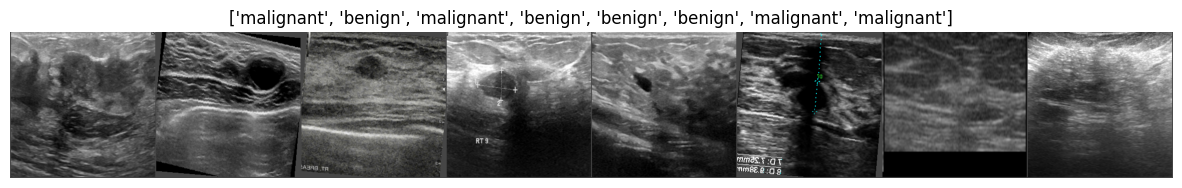

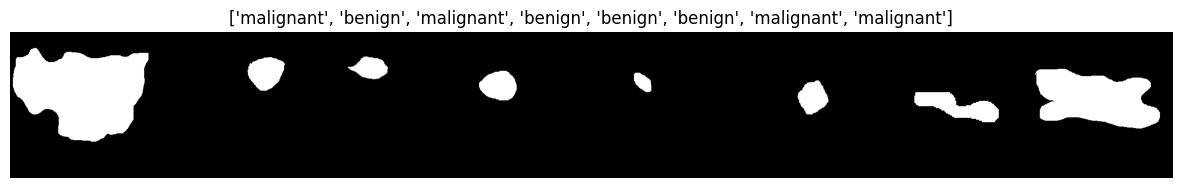

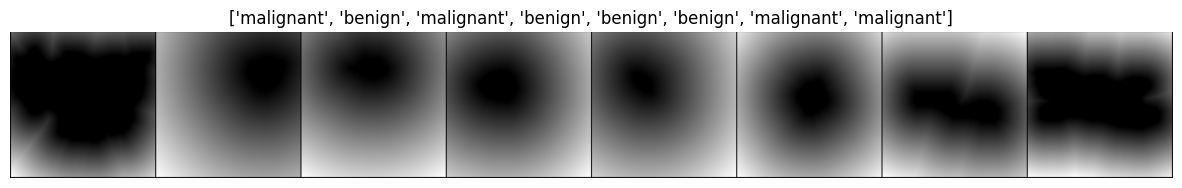

In [ ]:
fold=1
train_list_img, val_list_img, train_mask= get_list_train_val(fold)

train_dataset = MyDataset(train_list_img,us_features = df_fold1, train =True,  mask_path = train_mask,transforms =[transforms_dict['train'],transforms_dict['mask']])
train_dataloader = DataLoader(train_dataset,batch_size=8, shuffle = True, drop_last = True)

val_dataset = MyDataset(val_list_img,transforms=[transforms_dict['validation']])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


dataset_sizes = {'train' : len(train_dataset),'validation':len(val_dataset), 'mask' :len(train_dataset)}

inputs,classes,masks,dist_map,us_features = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

out1 = torchvision.utils.make_grid(masks)
imshow2(out1, title=[class_names[x] for x in classes])
out2 = torchvision.utils.make_grid(dist_map)
imshow2(out2, title=[class_names[x] for x in classes])


In [ ]:
fold=1
base_model = my_model()
base_model = base_model.to(device)
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/inception_fold{fold}_newdata_seb_resprep_{dataset}_normalized{process}_cbam_add.bin'), strict= False)
torch.save(base_model.state_dict(), f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add_initialize.bin')
base_model, history = train_model(fold, base_model,loss_fn3,loss_fn4,loss_fn5,loss_fn6,(train_dataloader), val_dataloader, dataset_sizes, device)
plot_training_history(history)

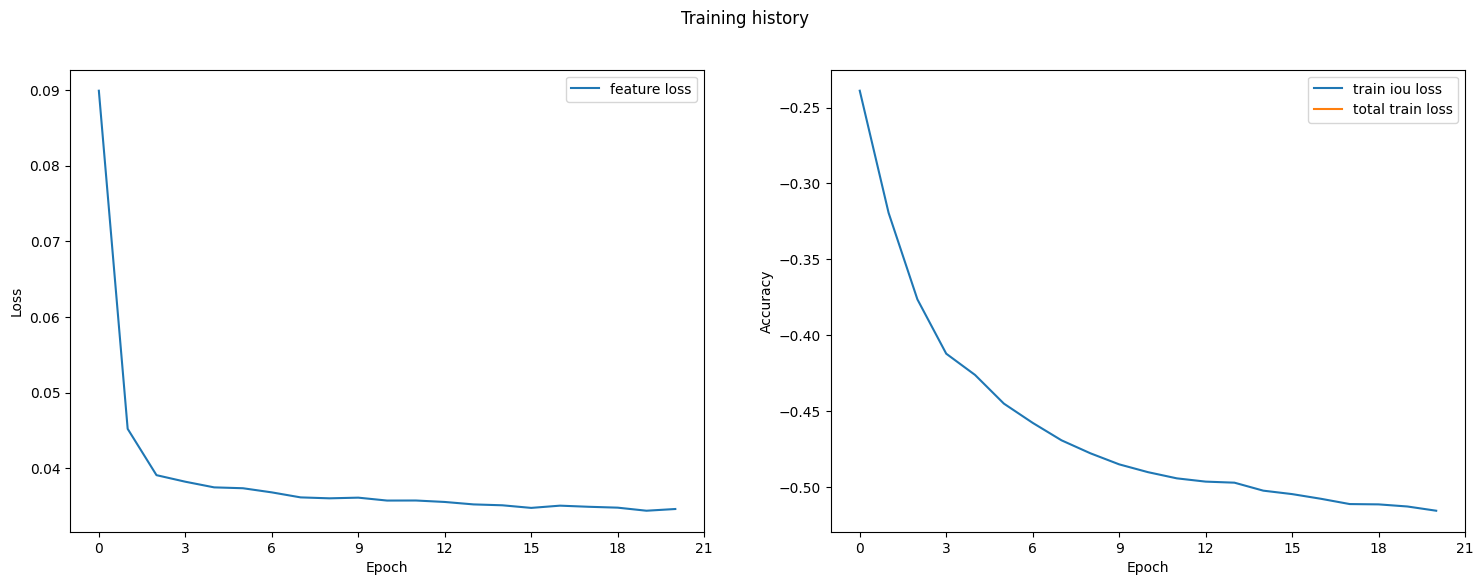

In [ ]:
plot_training_history2(history)

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc


class_names=['benign','malignant']
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
y_pred, y_test, y_pred01 = get_predictions(fold, base_model )
#print(y_pred01)
report=classification_report(y_test, y_pred, target_names=class_names,output_dict= True)
# print(classification_report(y_test, y_pred, target_names=class_names))

#specificity
cm = confusion_matrix(y_test, y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#Accuracy
acc= (TP+TN)/(TP+TN+FN+FP)
print("Accuracy:", acc)

#Sen
sp= TN/(TN+FP)
print('Specificity: ', sp )

#Spe
sn= TP/(TP+FN)
print('Sensitivity: ', sn )

#F_1
F1= (TP+TP)/(TP+TP+FN+FP)
print("F1 score:", F1)

#MCC
mcc = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
print("MCC score:", mcc)

#AUC
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
print([round(value, 2) for value in y_pred01_cpu])
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]
print(y_test_cpu)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
print(thresholds)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics = metrics.append({'Fold': fold, 'Accuracy': acc, 'Sensitivity': sn, 'Specificity': sp, 'F-1 score': F1,
                'MCC': mcc, 'AUC': roc_auc}, ignore_index=True)


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'
model_name=f'8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add'
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')


# **Fold2**

tensor(1.)
tensor(1., dtype=torch.float64)


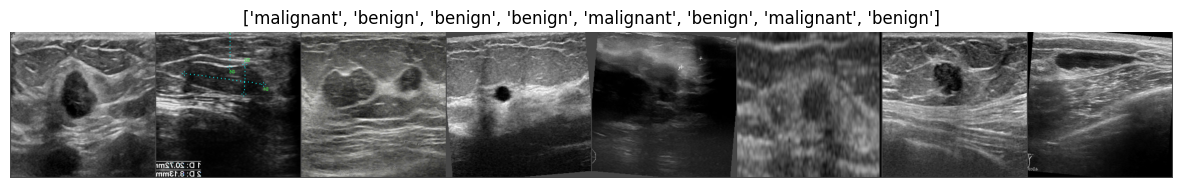

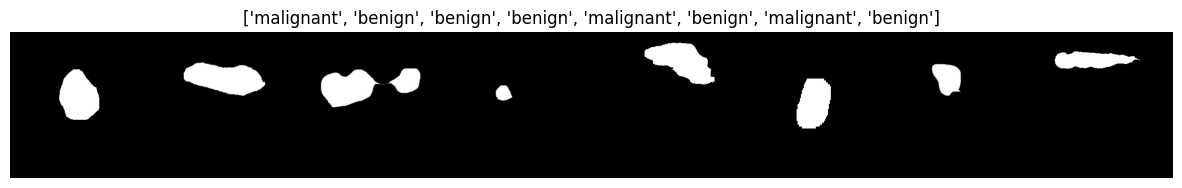

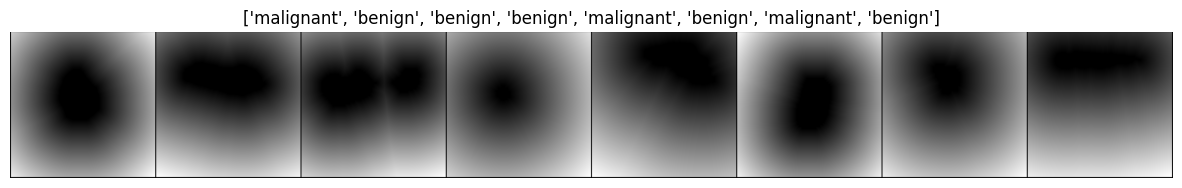

In [ ]:
fold=2
train_list_img, val_list_img, train_mask= get_list_train_val(fold)

train_dataset = MyDataset(train_list_img,us_features = df_fold2, train =True,  mask_path = train_mask,transforms =[transforms_dict['train'],transforms_dict['mask']])
train_dataloader = DataLoader(train_dataset,batch_size=8, shuffle = True, drop_last = True)

val_dataset = MyDataset(val_list_img,transforms=[transforms_dict['validation']])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


dataset_sizes = {'train' : len(train_dataset),'validation':len(val_dataset), 'mask' :len(train_dataset)}

inputs,classes,masks,dist_map,us_features = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

out1 = torchvision.utils.make_grid(masks)
imshow2(out1, title=[class_names[x] for x in classes])
out2 = torchvision.utils.make_grid(dist_map)
imshow2(out2, title=[class_names[x] for x in classes])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-d

tensor(0.0940, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  1%|          | 2/193 [00:02<03:16,  1.03s/it]

tensor(0.0898, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 3/193 [00:02<02:33,  1.24it/s]

tensor(0.0662, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 4/193 [00:03<02:13,  1.41it/s]

tensor(0.0908, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 5/193 [00:04<02:05,  1.50it/s]

tensor(0.0886, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 6/193 [00:04<01:58,  1.57it/s]

tensor(0.0859, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 7/193 [00:05<01:53,  1.64it/s]

tensor(0.0862, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▍         | 8/193 [00:05<01:49,  1.69it/s]

tensor(0.0815, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▍         | 9/193 [00:06<01:55,  1.59it/s]

tensor(0.0916, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▌         | 10/193 [00:06<01:48,  1.68it/s]

tensor(0.1070, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 11/193 [00:07<01:44,  1.74it/s]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 12/193 [00:07<01:36,  1.87it/s]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 13/193 [00:08<01:32,  1.96it/s]

tensor(0.0925, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 14/193 [00:08<01:25,  2.08it/s]

tensor(0.1065, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 15/193 [00:09<01:23,  2.13it/s]

tensor(0.0982, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 16/193 [00:09<01:18,  2.24it/s]

tensor(0.0996, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 17/193 [00:10<01:16,  2.29it/s]

tensor(0.0939, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 18/193 [00:10<01:13,  2.38it/s]

tensor(0.0873, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|▉         | 19/193 [00:10<01:10,  2.45it/s]

tensor(0.0976, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|█         | 20/193 [00:11<01:09,  2.47it/s]

tensor(0.0868, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█         | 21/193 [00:11<01:10,  2.44it/s]

tensor(0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█▏        | 22/193 [00:12<01:10,  2.44it/s]

tensor(0.1030, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 23/193 [00:12<01:09,  2.44it/s]

tensor(0.1001, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 24/193 [00:12<01:09,  2.44it/s]

tensor(0.0944, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 25/193 [00:13<01:08,  2.45it/s]

tensor(0.0801, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 26/193 [00:13<01:07,  2.46it/s]

tensor(0.0829, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 14%|█▍        | 27/193 [00:14<01:07,  2.47it/s]

tensor(0.0728, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▍        | 28/193 [00:14<01:07,  2.46it/s]

tensor(0.0673, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▌        | 29/193 [00:14<01:06,  2.47it/s]

tensor(0.0988, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 30/193 [00:15<01:05,  2.47it/s]

tensor(0.1002, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 31/193 [00:15<01:06,  2.45it/s]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 32/193 [00:16<01:05,  2.45it/s]

tensor(0.0899, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 33/193 [00:16<01:05,  2.44it/s]

tensor(0.1020, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 34/193 [00:17<01:12,  2.18it/s]

tensor(0.1133, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 35/193 [00:17<01:20,  1.97it/s]

tensor(0.0872, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▊        | 36/193 [00:18<01:23,  1.88it/s]

tensor(0.0991, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▉        | 37/193 [00:18<01:24,  1.84it/s]

tensor(0.0936, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|█▉        | 38/193 [00:19<01:25,  1.81it/s]

tensor(0.0948, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|██        | 39/193 [00:19<01:24,  1.83it/s]

tensor(0.0839, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 40/193 [00:20<01:24,  1.82it/s]

tensor(0.0957, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 41/193 [00:20<01:15,  2.02it/s]

tensor(0.0675, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 42/193 [00:21<01:09,  2.18it/s]

tensor(0.0652, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 43/193 [00:21<01:06,  2.26it/s]

tensor(0.0856, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 44/193 [00:22<01:02,  2.37it/s]

tensor(0.0759, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 45/193 [00:22<01:03,  2.32it/s]

tensor(0.0743, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 46/193 [00:22<01:01,  2.38it/s]

tensor(0.0963, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 47/193 [00:23<00:59,  2.44it/s]

tensor(0.0941, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▍       | 48/193 [00:23<01:01,  2.36it/s]

tensor(0.0962, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▌       | 49/193 [00:24<00:59,  2.42it/s]

tensor(0.0904, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▌       | 50/193 [00:24<00:59,  2.39it/s]

tensor(0.0923, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▋       | 51/193 [00:24<00:57,  2.48it/s]

tensor(0.0715, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 52/193 [00:25<00:56,  2.51it/s]

tensor(0.0934, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 53/193 [00:25<00:57,  2.43it/s]

tensor(0.0861, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 54/193 [00:26<00:56,  2.46it/s]

tensor(0.0861, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 55/193 [00:26<00:57,  2.38it/s]

tensor(0.0775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 29%|██▉       | 56/193 [00:27<00:58,  2.34it/s]

tensor(0.0924, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|██▉       | 57/193 [00:27<00:56,  2.40it/s]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|███       | 58/193 [00:27<00:56,  2.38it/s]

tensor(0.0767, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 59/193 [00:28<00:56,  2.36it/s]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 60/193 [00:28<00:56,  2.37it/s]

tensor(0.0956, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 61/193 [00:29<00:53,  2.44it/s]

tensor(0.0906, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 62/193 [00:29<00:54,  2.42it/s]

tensor(0.0780, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 63/193 [00:29<00:53,  2.44it/s]

tensor(0.1080, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 64/193 [00:30<00:53,  2.42it/s]

tensor(0.0983, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▎      | 65/193 [00:30<00:57,  2.21it/s]

tensor(0.0715, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▍      | 66/193 [00:31<01:03,  2.01it/s]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▍      | 67/193 [00:32<01:05,  1.93it/s]

tensor(0.0913, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▌      | 68/193 [00:32<01:06,  1.88it/s]

tensor(0.0913, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▌      | 69/193 [00:33<01:07,  1.83it/s]

tensor(0.0835, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▋      | 70/193 [00:33<01:08,  1.81it/s]

tensor(0.0607, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 71/193 [00:34<01:07,  1.81it/s]

tensor(0.0912, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 72/193 [00:34<01:01,  1.97it/s]

tensor(0.0933, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 73/193 [00:35<00:56,  2.12it/s]

tensor(0.0830, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 74/193 [00:35<00:55,  2.16it/s]

tensor(0.0716, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 75/193 [00:35<00:52,  2.24it/s]

tensor(0.0798, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 76/193 [00:36<00:50,  2.32it/s]

tensor(0.0910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|███▉      | 77/193 [00:36<00:48,  2.41it/s]

tensor(0.0958, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|████      | 78/193 [00:37<00:48,  2.39it/s]

tensor(0.0926, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████      | 79/193 [00:37<00:46,  2.47it/s]

tensor(0.0704, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████▏     | 80/193 [00:37<00:45,  2.49it/s]

tensor(0.0810, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 81/193 [00:38<00:45,  2.47it/s]

tensor(0.1050, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 82/193 [00:38<00:44,  2.51it/s]

tensor(0.0824, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 43%|████▎     | 83/193 [00:39<00:44,  2.47it/s]

tensor(0.0824, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▎     | 84/193 [00:39<00:44,  2.47it/s]

tensor(0.1007, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▍     | 85/193 [00:39<00:44,  2.44it/s]

tensor(0.1127, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▍     | 86/193 [00:40<00:45,  2.36it/s]

tensor(0.0919, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▌     | 87/193 [00:40<00:44,  2.36it/s]

tensor(0.0975, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 88/193 [00:41<00:44,  2.37it/s]

tensor(0.0753, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 89/193 [00:41<00:45,  2.31it/s]

tensor(0.0917, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 90/193 [00:42<00:43,  2.35it/s]

tensor(0.0937, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 91/193 [00:42<00:44,  2.30it/s]

tensor(0.0811, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 92/193 [00:42<00:43,  2.31it/s]

tensor(0.0922, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 93/193 [00:43<00:42,  2.36it/s]

tensor(0.1023, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▊     | 94/193 [00:43<00:42,  2.36it/s]

tensor(0.1059, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▉     | 95/193 [00:44<00:41,  2.34it/s]

tensor(0.0716, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|████▉     | 96/193 [00:44<00:47,  2.05it/s]

tensor(0.0707, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|█████     | 97/193 [00:45<00:50,  1.90it/s]

tensor(0.0902, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████     | 98/193 [00:46<00:51,  1.85it/s]

tensor(0.0893, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████▏    | 99/193 [00:46<00:50,  1.86it/s]

tensor(0.0721, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 100/193 [00:47<00:51,  1.81it/s]

tensor(0.0838, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 101/193 [00:47<00:50,  1.82it/s]

tensor(0.1038, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 102/193 [00:48<00:49,  1.84it/s]

tensor(0.0897, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 103/193 [00:48<00:46,  1.95it/s]

tensor(0.0800, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 104/193 [00:49<00:42,  2.09it/s]

tensor(0.1098, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 105/193 [00:49<00:40,  2.18it/s]

tensor(0.0749, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▍    | 106/193 [00:49<00:38,  2.27it/s]

tensor(0.0824, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▌    | 107/193 [00:50<00:36,  2.39it/s]

tensor(0.0909, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▌    | 108/193 [00:50<00:34,  2.43it/s]

tensor(0.0966, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▋    | 109/193 [00:51<00:33,  2.50it/s]

tensor(0.0734, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 57%|█████▋    | 110/193 [00:51<00:33,  2.49it/s]

tensor(0.0945, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 111/193 [00:51<00:32,  2.53it/s]

tensor(0.0874, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 112/193 [00:52<00:32,  2.46it/s]

tensor(0.0726, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▊    | 113/193 [00:52<00:32,  2.43it/s]

tensor(0.0722, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▉    | 114/193 [00:53<00:32,  2.45it/s]

tensor(0.0719, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|█████▉    | 115/193 [00:53<00:31,  2.47it/s]

tensor(0.0974, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|██████    | 116/193 [00:53<00:30,  2.49it/s]

tensor(0.0863, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 117/193 [00:54<00:31,  2.44it/s]

tensor(0.0862, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 118/193 [00:54<00:30,  2.47it/s]

tensor(0.0813, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 119/193 [00:55<00:29,  2.48it/s]

tensor(0.0979, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 120/193 [00:55<00:29,  2.47it/s]

tensor(0.0944, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 121/193 [00:55<00:28,  2.50it/s]

tensor(0.1016, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 122/193 [00:56<00:28,  2.46it/s]

tensor(0.1108, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▎   | 123/193 [00:56<00:28,  2.45it/s]

tensor(0.0679, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▍   | 124/193 [00:57<00:28,  2.39it/s]

tensor(0.1101, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▍   | 125/193 [00:57<00:28,  2.38it/s]

tensor(0.0945, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▌   | 126/193 [00:57<00:27,  2.44it/s]

tensor(0.0912, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▌   | 127/193 [00:58<00:28,  2.29it/s]

tensor(0.1030, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▋   | 128/193 [00:59<00:30,  2.14it/s]

tensor(0.0648, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 129/193 [00:59<00:32,  1.95it/s]

tensor(0.0996, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 130/193 [01:00<00:36,  1.72it/s]

tensor(0.0772, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 131/193 [01:00<00:35,  1.74it/s]

tensor(0.0633, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 132/193 [01:01<00:35,  1.72it/s]

tensor(0.1027, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 133/193 [01:02<00:34,  1.75it/s]

tensor(0.0825, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 134/193 [01:02<00:31,  1.90it/s]

tensor(0.0685, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|██████▉   | 135/193 [01:02<00:28,  2.04it/s]

tensor(0.0806, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|███████   | 136/193 [01:03<00:26,  2.19it/s]

tensor(0.0985, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 71%|███████   | 137/193 [01:03<00:24,  2.29it/s]

tensor(0.0938, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 138/193 [01:04<00:23,  2.32it/s]

tensor(0.0886, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 139/193 [01:04<00:23,  2.26it/s]

tensor(0.0865, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 140/193 [01:04<00:23,  2.30it/s]

tensor(0.0903, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 141/193 [01:05<00:21,  2.37it/s]

tensor(0.0976, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▎  | 142/193 [01:05<00:21,  2.36it/s]

tensor(0.1012, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▍  | 143/193 [01:06<00:21,  2.37it/s]

tensor(0.1055, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▍  | 144/193 [01:06<00:21,  2.33it/s]

tensor(0.0871, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▌  | 145/193 [01:07<00:20,  2.38it/s]

tensor(0.1003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 146/193 [01:07<00:20,  2.34it/s]

tensor(0.0997, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 147/193 [01:07<00:19,  2.39it/s]

tensor(0.0809, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 148/193 [01:08<00:18,  2.42it/s]

tensor(0.0874, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 149/193 [01:08<00:18,  2.39it/s]

tensor(0.0901, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 150/193 [01:09<00:18,  2.38it/s]

tensor(0.0796, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 151/193 [01:09<00:17,  2.34it/s]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 152/193 [01:10<00:17,  2.33it/s]

tensor(0.0875, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 153/193 [01:10<00:16,  2.41it/s]

tensor(0.0962, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|███████▉  | 154/193 [01:10<00:16,  2.43it/s]

tensor(0.0739, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|████████  | 155/193 [01:11<00:15,  2.41it/s]

tensor(0.0836, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████  | 156/193 [01:11<00:15,  2.41it/s]

tensor(0.0708, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████▏ | 157/193 [01:12<00:14,  2.46it/s]

tensor(0.0799, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 158/193 [01:12<00:15,  2.23it/s]

tensor(0.0823, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 159/193 [01:13<00:16,  2.05it/s]

tensor(0.1108, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 160/193 [01:13<00:17,  1.94it/s]

tensor(0.0690, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 161/193 [01:14<00:16,  1.92it/s]

tensor(0.0615, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 162/193 [01:14<00:16,  1.85it/s]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 163/193 [01:15<00:16,  1.81it/s]

tensor(0.1019, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▍ | 164/193 [01:15<00:15,  1.86it/s]

tensor(0.0854, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▌ | 165/193 [01:16<00:13,  2.04it/s]

tensor(0.0945, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 86%|████████▌ | 166/193 [01:16<00:12,  2.13it/s]

tensor(0.0811, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 167/193 [01:17<00:11,  2.21it/s]

tensor(0.0863, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 168/193 [01:17<00:10,  2.31it/s]

tensor(0.1047, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 169/193 [01:17<00:10,  2.34it/s]

tensor(0.1095, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 170/193 [01:18<00:09,  2.43it/s]

tensor(0.0798, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▊ | 171/193 [01:18<00:08,  2.45it/s]

tensor(0.0843, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▉ | 172/193 [01:19<00:08,  2.45it/s]

tensor(0.0680, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|████████▉ | 173/193 [01:19<00:08,  2.46it/s]

tensor(0.0881, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|█████████ | 174/193 [01:19<00:07,  2.48it/s]

tensor(0.0827, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 175/193 [01:20<00:07,  2.46it/s]

tensor(0.0937, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 176/193 [01:20<00:06,  2.43it/s]

tensor(0.1002, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 177/193 [01:21<00:06,  2.45it/s]

tensor(0.0844, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 178/193 [01:21<00:06,  2.48it/s]

tensor(0.0722, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 179/193 [01:21<00:05,  2.50it/s]

tensor(0.1050, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 180/193 [01:22<00:05,  2.51it/s]

tensor(0.1005, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 181/193 [01:22<00:04,  2.53it/s]

tensor(0.0695, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 182/193 [01:23<00:04,  2.51it/s]

tensor(0.0775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▍| 183/193 [01:23<00:03,  2.54it/s]

tensor(0.0910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▌| 184/193 [01:23<00:03,  2.57it/s]

tensor(0.0916, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▌| 185/193 [01:24<00:03,  2.52it/s]

tensor(0.0717, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▋| 186/193 [01:24<00:02,  2.56it/s]

tensor(0.1046, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 187/193 [01:25<00:02,  2.51it/s]

tensor(0.0803, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 188/193 [01:25<00:02,  2.42it/s]

tensor(0.0864, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 189/193 [01:26<00:01,  2.37it/s]

tensor(0.0676, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 190/193 [01:26<00:01,  2.19it/s]

tensor(0.0706, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 191/193 [01:27<00:00,  2.04it/s]

tensor(0.1013, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 192/193 [01:27<00:00,  1.93it/s]

tensor(0.0990, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


100%|██████████| 193/193 [01:28<00:00,  2.19it/s]


tensor(0.0795, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 1/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -1.145853444252704 accuracy 0.977979274611399 boundary_loss-5.12176807725725 iou_loss2 -0.8789895661754311 iou_loss1 -0.32590759672958 nbrloss 0.1458864585723284 feature_loss 0.0457886523938704 crossentropyloss 0.08572345030876456
Val   loss 0.3715978106173376 accuracy 0.8541666666666666

Epoch 2/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -1.5748266831958617 accuracy 0.9727979274611399 boundary_loss-7.256181325122367 iou_loss2 -0.8992211120733943 iou_loss1 -0.3888214630475316 nbrloss 0.13501752337797937 feature_loss 0.03984650739811245 crossentropyloss 0.10302994715006433
Val   loss 0.45374568418289224 accuracy 0.8833333333333333

Epoch 3/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.86it/s]


Train loss -1.7948219772906482 accuracy 0.9805699481865285 boundary_loss-8.17315256610836 iou_loss2 -0.9068951233063337 iou_loss1 -0.42216302964044977 nbrloss 0.13153395199559514 feature_loss 0.03878176188183263 crossentropyloss 0.07543520359539577
Val   loss 0.31269706981256606 accuracy 0.8958333333333334

Epoch 4/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.84it/s]


Train loss -1.9626397154939905 accuracy 0.9928756476683938 boundary_loss-8.788274067161765 iou_loss2 -0.9126716463059341 iou_loss1 -0.4439495974871779 nbrloss 0.1279039855834116 feature_loss 0.037612626584816164 crossentropyloss 0.03699729023646042
Val   loss 0.41556326892071715 accuracy 0.9166666666666666

Epoch 5/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.84it/s]


Train loss -2.0249311334449906 accuracy 0.9896373056994818 boundary_loss-9.086376930240164 iou_loss2 -0.9153505820066817 iou_loss1 -0.45623469723321 nbrloss 0.12593990047052117 feature_loss 0.03694549814310562 crossentropyloss 0.03777878280183773
Val   loss 0.31305844155528273 accuracy 0.9125

Epoch 6/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.84it/s]


Train loss -2.045683954604231 accuracy 0.9838082901554405 boundary_loss-9.254154175067457 iou_loss2 -0.918109202940847 iou_loss1 -0.4657200073022299 nbrloss 0.12531989087094914 feature_loss 0.03698004949162352 crossentropyloss 0.053150742823243564
Val   loss 0.33820610737942236 accuracy 0.9

Epoch 00006: reducing learning rate of group 0 to 8.0000e-05.
Epoch 7/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.84it/s]


Train loss -2.1305052465679672 accuracy 0.9922279792746114 boundary_loss-9.568791139211033 iou_loss2 -0.9205362639278946 iou_loss1 -0.478823211835456 nbrloss 0.12396070920896037 feature_loss 0.036156044428482886 crossentropyloss 0.03471713441718428
Val   loss 0.3422107919274519 accuracy 0.9041666666666667

Epoch 8/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.1717211786103965 accuracy 0.9941709844559585 boundary_loss-9.730843299684427 iou_loss2 -0.9217683691434909 iou_loss1 -0.48484051536401934 nbrloss 0.12336138222810518 feature_loss 0.035895762950606605 crossentropyloss 0.027507410009531545
Val   loss 0.33219639911161114 accuracy 0.9208333333333333

Epoch 9/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.23188910566059 accuracy 0.9993523316062176 boundary_loss-9.92243606917121 iou_loss2 -0.924217057042789 iou_loss1 -0.49357331849132796 nbrloss 0.12126530058334528 feature_loss 0.0355248540359998 crossentropyloss 0.008350641304947354
Val   loss 0.39618339035271977 accuracy 0.9125

Epoch 00009: reducing learning rate of group 0 to 6.4000e-05.
Epoch 10/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.250287509067661 accuracy 0.9961139896373057 boundary_loss-10.066073166287794 iou_loss2 -0.925122973214777 iou_loss1 -0.49928248777908363 nbrloss 0.12181242953001527 feature_loss 0.035473438225918176 crossentropyloss 0.01989839100989168
Val   loss 0.3750486420428691 accuracy 0.9166666666666666

Epoch 11/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.2690679774183278 accuracy 0.9961139896373057 boundary_loss-10.124067874747341 iou_loss2 -0.926425219199818 iou_loss1 -0.5034530780475992 nbrloss 0.12068033033084376 feature_loss 0.035244642385315404 crossentropyloss 0.014060731006506046
Val   loss 0.39043795940912485 accuracy 0.8958333333333334

Epoch 12/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.2786097927661366 accuracy 0.9967616580310881 boundary_loss-10.162357450542785 iou_loss2 -0.9270681652380395 iou_loss1 -0.5055261175558357 nbrloss 0.12047373333588783 feature_loss 0.03512101244528831 crossentropyloss 0.012773710911851642
Val   loss 0.6079842833181223 accuracy 0.8916666666666667

Epoch 00012: reducing learning rate of group 0 to 5.1200e-05.
Epoch 13/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.2681004337832094 accuracy 0.9922279792746114 boundary_loss-10.1747968929867 iou_loss2 -0.9272700474052231 iou_loss1 -0.5057619014861052 nbrloss 0.12124065421714685 feature_loss 0.03531659230435451 crossentropyloss 0.025685548120500386
Val   loss 0.5102043428186638 accuracy 0.8625

Epoch 14/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.297689588707047 accuracy 0.9987046632124352 boundary_loss-10.227228845760973 iou_loss2 -0.9279740113050826 iou_loss1 -0.509460956167063 nbrloss 0.12070339057266403 feature_loss 0.03497864322379772 crossentropyloss 0.007604634987945558
Val   loss 0.3504312633843559 accuracy 0.925

Epoch 15/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.3056397626320706 accuracy 0.9974093264248705 boundary_loss-10.296138559501603 iou_loss2 -0.9285696423733173 iou_loss1 -0.5126532827325435 nbrloss 0.12025885476967213 feature_loss 0.03503576629442872 crossentropyloss 0.014277189948452501
Val   loss 0.48945084732646743 accuracy 0.8833333333333333

Epoch 00015: reducing learning rate of group 0 to 4.0960e-05.
Epoch 16/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.313255134129633 accuracy 0.9993523316062176 boundary_loss-10.306272850817276 iou_loss2 -0.9292377434246281 iou_loss1 -0.5140820335538894 nbrloss 0.12047644669836667 feature_loss 0.03459615383895567 crossentropyloss 0.009108491411277002
Val   loss 0.4549636196480909 accuracy 0.8916666666666667

Epoch 17/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.3271780748658557 accuracy 1.0 boundary_loss-10.342496816312567 iou_loss2 -0.9292744172669445 iou_loss1 -0.5157016894051448 nbrloss 0.12002319699742016 feature_loss 0.03448533164482043 crossentropyloss 0.0028633409651892664
Val   loss 0.4917122969268045 accuracy 0.8833333333333333

Epoch 18/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.341648317467077 accuracy 1.0 boundary_loss-10.41231082404381 iou_loss2 -0.9298565545230332 iou_loss1 -0.5182189907434691 nbrloss 0.12008032889872634 feature_loss 0.034630422485229885 crossentropyloss 0.002949852787273082
Val   loss 0.47486012283479795 accuracy 0.9041666666666667

Epoch 00018: reducing learning rate of group 0 to 3.2768e-05.
Epoch 19/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.34613376955981 accuracy 1.0 boundary_loss-10.428898799669922 iou_loss2 -0.9300698724435401 iou_loss1 -0.5189133884066744 nbrloss 0.11979435009814297 feature_loss 0.03440893346376215 crossentropyloss 0.0020428824559224463
Val   loss 0.508236018450892 accuracy 0.9041666666666667

Epoch 20/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -2.359199046347292 accuracy 1.0 boundary_loss-10.48985140596889 iou_loss2 -0.9304605163440803 iou_loss1 -0.521864429039041 nbrloss 0.12038211810156471 feature_loss 0.03411371458244602 crossentropyloss 0.0017484322538927506
Val   loss 0.5485578261344927 accuracy 0.8916666666666667



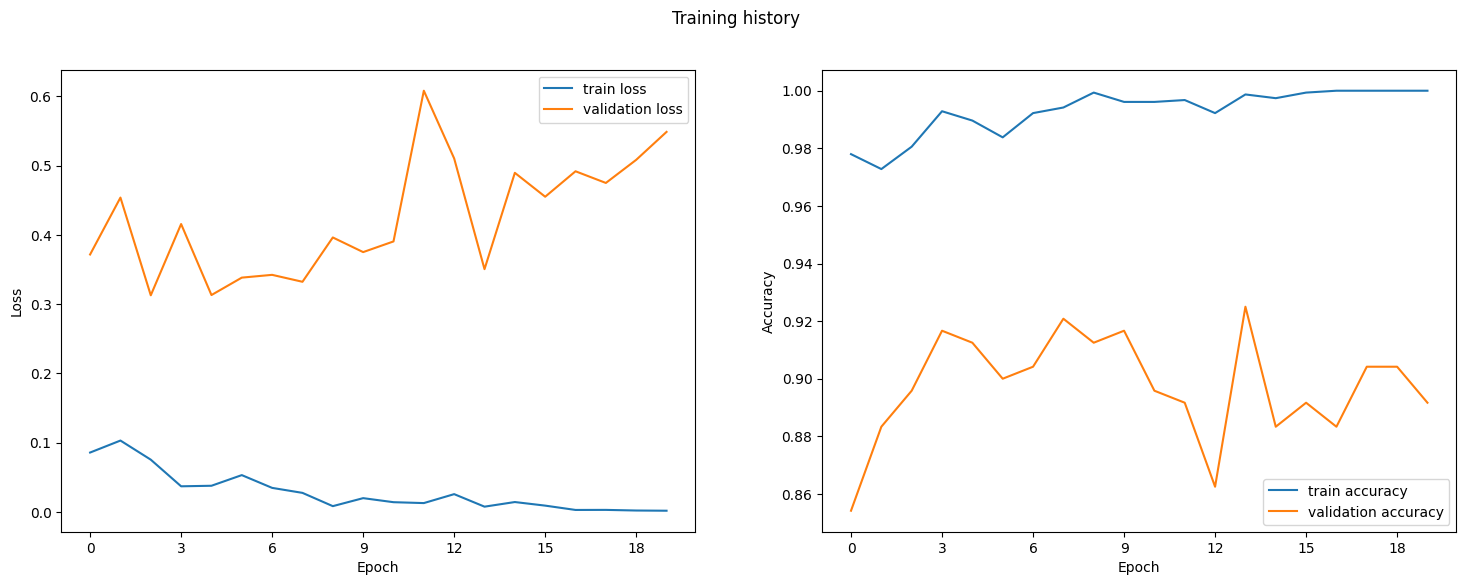

In [ ]:
base_model = my_model()
base_model = base_model.to(device)
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/inception_fold{fold}_newdata_seb_resprep_{dataset}_normalized{process}_cbam_add.bin'), strict=False)
torch.save(base_model.state_dict(), f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add_initialize.bin')
base_model, history = train_model(fold, base_model,loss_fn3,loss_fn4,loss_fn5,loss_fn6,(train_dataloader), val_dataloader, dataset_sizes, device)
plot_training_history(history)

  0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 37/37 [00:07<00:00,  4.74it/s]
<ipython-input-121-fddf8a4470dd>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'

[39, 121, 122, 127, 132, 133, 135, 178, 185, 189, 192, 206, 209, 245, 255, 258, 266, 267, 272, 280, 281, 282, 292]
Accuracy: 0.9220338983050848
Specificity:  0.96045197740113
Sensitivity:  0.864406779661017
F1 score: 0.8986784140969163
MCC score: 0.8372159723321332
AUC score: 0.9626544096523988
              precision    recall  f1-score     support
benign         0.913978  0.960452  0.936639  177.000000
malignant      0.935780  0.864407  0.898678  118.000000
accuracy       0.922034  0.922034  0.922034    0.922034
macro avg      0.924879  0.912429  0.917659  295.000000
weighted avg   0.922699  0.922034  0.921455  295.000000


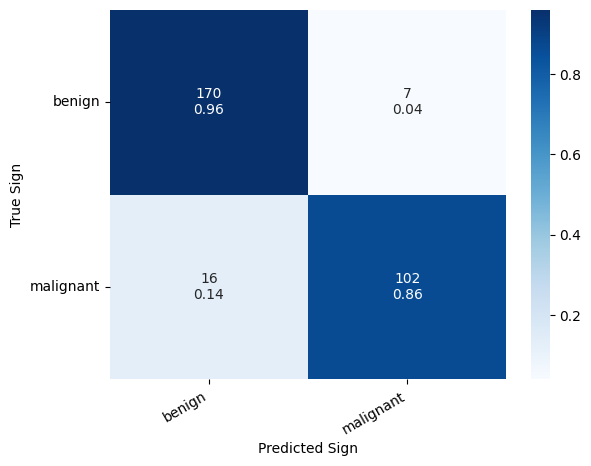

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc


class_names=['benign','malignant']
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
y_pred, y_test, y_pred01 = get_predictions(fold, base_model )
#print(y_pred01)
report=classification_report(y_test, y_pred, target_names=class_names,output_dict= True)
# print(classification_report(y_test, y_pred, target_names=class_names))

#specificity
cm = confusion_matrix(y_test, y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#Accuracy
acc= (TP+TN)/(TP+TN+FN+FP)
print("Accuracy:", acc)

#Sen
sp= TN/(TN+FP)
print('Specificity: ', sp )

#Spe
sn= TP/(TP+FN)
print('Sensitivity: ', sn )

#F_1
F1= (TP+TP)/(TP+TP+FN+FP)
print("F1 score:", F1)

#MCC
mcc = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
print("MCC score:", mcc)

#AUC
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)

metrics = metrics.append({'Fold': fold, 'Accuracy': acc, 'Sensitivity': sn, 'Specificity': sp, 'F-1 score': F1,
                'MCC': mcc, 'AUC': roc_auc}, ignore_index=True)


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'
model_name=f'8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add'
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')


# **Fold3**

tensor(1.)
tensor(1., dtype=torch.float64)


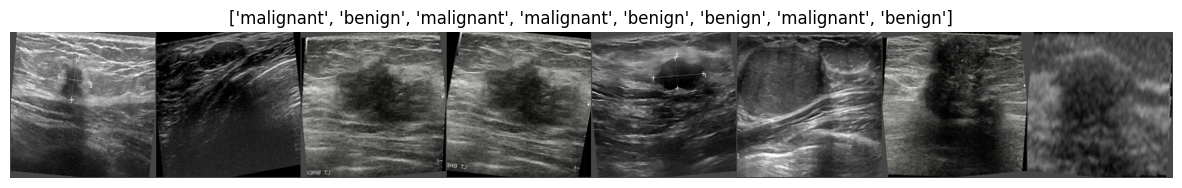

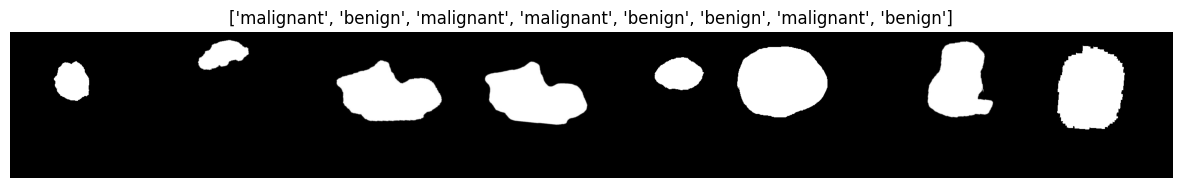

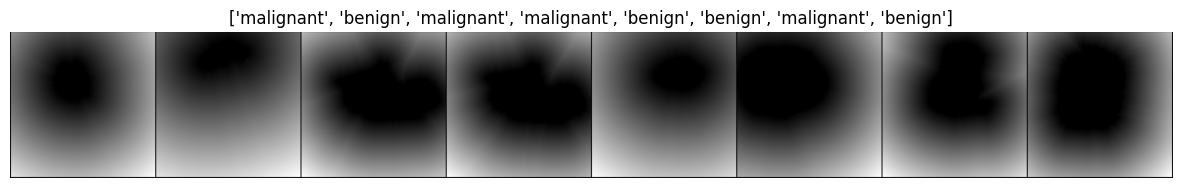

In [ ]:
fold= 3
train_list_img, val_list_img, train_mask= get_list_train_val(fold)

train_dataset = MyDataset(train_list_img,us_features = df_fold3, train =True,  mask_path = train_mask,transforms =[transforms_dict['train'],transforms_dict['mask']])
train_dataloader = DataLoader(train_dataset,batch_size=8, shuffle = True, drop_last = True)

val_dataset = MyDataset(val_list_img,transforms=[transforms_dict['validation']])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


dataset_sizes = {'train' : len(train_dataset),'validation':len(val_dataset), 'mask' :len(train_dataset)}

inputs,classes,masks,dist_map,us_features = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
out1 = torchvision.utils.make_grid(masks)
imshow2(out1, title=[class_names[x] for x in classes])
out2 = torchvision.utils.make_grid(dist_map)
imshow2(out2, title=[class_names[x] for x in classes])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-d

tensor(0.0928, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  1%|          | 2/193 [00:18<27:58,  8.79s/it]

tensor(0.0661, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 3/193 [00:23<21:03,  6.65s/it]

tensor(0.0788, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 4/193 [00:26<16:36,  5.27s/it]

tensor(0.0861, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 5/193 [00:31<16:36,  5.30s/it]

tensor(0.0894, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 6/193 [00:34<14:12,  4.56s/it]

tensor(0.0834, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 7/193 [00:39<13:54,  4.49s/it]

tensor(0.0856, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▍         | 8/193 [00:42<12:47,  4.15s/it]

tensor(0.0714, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▍         | 9/193 [00:48<14:26,  4.71s/it]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▌         | 10/193 [00:54<15:56,  5.22s/it]

tensor(0.0944, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 11/193 [01:00<15:55,  5.25s/it]

tensor(0.0784, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 12/193 [01:05<16:11,  5.36s/it]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 13/193 [01:10<15:23,  5.13s/it]

tensor(0.0736, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 14/193 [01:15<15:22,  5.16s/it]

tensor(0.0925, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 15/193 [01:19<14:20,  4.83s/it]

tensor(0.0870, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 16/193 [01:26<16:19,  5.53s/it]

tensor(0.0793, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 17/193 [01:32<16:41,  5.69s/it]

tensor(0.0755, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 18/193 [01:37<15:51,  5.44s/it]

tensor(0.0947, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|▉         | 19/193 [01:42<15:35,  5.37s/it]

tensor(0.0655, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|█         | 20/193 [01:46<14:19,  4.97s/it]

tensor(0.0851, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█         | 21/193 [01:52<14:44,  5.14s/it]

tensor(0.0740, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█▏        | 22/193 [01:59<15:52,  5.57s/it]

tensor(0.0803, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 23/193 [02:04<15:37,  5.52s/it]

tensor(0.1090, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 24/193 [02:11<16:36,  5.90s/it]

tensor(0.0929, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 25/193 [02:18<17:36,  6.29s/it]

tensor(0.0812, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 26/193 [02:24<16:55,  6.08s/it]

tensor(0.0916, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 14%|█▍        | 27/193 [02:27<15:04,  5.45s/it]

tensor(0.0649, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▍        | 28/193 [02:33<14:46,  5.37s/it]

tensor(0.0793, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▌        | 29/193 [02:38<14:19,  5.24s/it]

tensor(0.0979, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 30/193 [02:42<13:30,  4.97s/it]

tensor(0.0759, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 31/193 [02:49<15:29,  5.74s/it]

tensor(0.0985, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 32/193 [02:53<14:00,  5.22s/it]

tensor(0.0863, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 33/193 [02:56<11:55,  4.47s/it]

tensor(0.0831, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 34/193 [03:02<12:46,  4.82s/it]

tensor(0.0732, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 35/193 [03:07<13:02,  4.95s/it]

tensor(0.0815, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▊        | 36/193 [03:13<13:33,  5.18s/it]

tensor(0.0811, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▉        | 37/193 [03:18<13:28,  5.19s/it]

tensor(0.0959, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|█▉        | 38/193 [03:21<11:36,  4.50s/it]

tensor(0.0711, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|██        | 39/193 [03:25<11:26,  4.46s/it]

tensor(0.0781, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 40/193 [03:33<13:55,  5.46s/it]

tensor(0.0757, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 41/193 [03:38<13:30,  5.33s/it]

tensor(0.0781, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 42/193 [03:43<13:02,  5.18s/it]

tensor(0.0712, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 43/193 [03:47<12:22,  4.95s/it]

tensor(0.0984, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 44/193 [03:51<11:07,  4.48s/it]

tensor(0.0868, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 45/193 [03:58<12:48,  5.19s/it]

tensor(0.0780, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 46/193 [04:02<12:28,  5.09s/it]

tensor(0.0837, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 47/193 [04:08<12:43,  5.23s/it]

tensor(0.0864, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▍       | 48/193 [04:13<12:21,  5.12s/it]

tensor(0.0910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▌       | 49/193 [04:17<11:20,  4.73s/it]

tensor(0.0947, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▌       | 50/193 [04:24<12:50,  5.39s/it]

tensor(0.1058, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▋       | 51/193 [04:29<12:46,  5.40s/it]

tensor(0.0877, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 52/193 [04:36<13:59,  5.96s/it]

tensor(0.0753, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 53/193 [04:41<13:19,  5.71s/it]

tensor(0.0741, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 54/193 [04:48<13:34,  5.86s/it]

tensor(0.0790, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 55/193 [04:54<13:54,  6.05s/it]

tensor(0.0804, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 29%|██▉       | 56/193 [04:59<13:03,  5.72s/it]

tensor(0.0860, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|██▉       | 57/193 [05:04<12:14,  5.40s/it]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|███       | 58/193 [05:09<12:02,  5.35s/it]

tensor(0.0858, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 59/193 [05:15<12:35,  5.64s/it]

tensor(0.0741, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 60/193 [05:20<11:34,  5.23s/it]

tensor(0.0915, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 61/193 [05:25<11:38,  5.29s/it]

tensor(0.0891, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 62/193 [05:31<11:43,  5.37s/it]

tensor(0.0921, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 63/193 [05:37<12:10,  5.62s/it]

tensor(0.0904, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 64/193 [05:43<12:35,  5.86s/it]

tensor(0.1015, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▎      | 65/193 [05:49<12:23,  5.81s/it]

tensor(0.0847, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▍      | 66/193 [05:54<12:02,  5.69s/it]

tensor(0.0780, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▍      | 67/193 [05:59<11:05,  5.28s/it]

tensor(0.0866, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▌      | 68/193 [06:06<12:26,  5.97s/it]

tensor(0.0790, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▌      | 69/193 [06:11<11:32,  5.59s/it]

tensor(0.0798, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▋      | 70/193 [06:15<10:21,  5.05s/it]

tensor(0.0731, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 71/193 [06:18<09:31,  4.69s/it]

tensor(0.0858, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 72/193 [06:24<10:09,  5.04s/it]

tensor(0.0852, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 73/193 [06:31<10:48,  5.41s/it]

tensor(0.0762, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 74/193 [06:37<11:01,  5.56s/it]

tensor(0.0862, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 75/193 [06:42<10:57,  5.57s/it]

tensor(0.0973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 76/193 [06:46<10:00,  5.13s/it]

tensor(0.0870, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|███▉      | 77/193 [06:52<10:22,  5.36s/it]

tensor(0.0996, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|████      | 78/193 [06:57<09:59,  5.22s/it]

tensor(0.0771, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████      | 79/193 [07:02<09:47,  5.15s/it]

tensor(0.0839, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████▏     | 80/193 [07:06<08:52,  4.71s/it]

tensor(0.0940, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 81/193 [07:11<09:08,  4.90s/it]

tensor(0.0881, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 82/193 [07:17<09:36,  5.19s/it]

tensor(0.0857, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 43%|████▎     | 83/193 [07:23<09:54,  5.40s/it]

tensor(0.0815, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▎     | 84/193 [07:29<10:17,  5.67s/it]

tensor(0.1033, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▍     | 85/193 [07:35<10:23,  5.77s/it]

tensor(0.0904, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▍     | 86/193 [07:42<10:38,  5.97s/it]

tensor(0.1115, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▌     | 87/193 [07:46<09:31,  5.39s/it]

tensor(0.0854, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 88/193 [07:52<09:50,  5.62s/it]

tensor(0.0819, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 89/193 [07:58<10:11,  5.88s/it]

tensor(0.0846, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 90/193 [08:04<09:49,  5.72s/it]

tensor(0.0617, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 91/193 [08:10<09:54,  5.83s/it]

tensor(0.0825, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 92/193 [08:17<10:22,  6.17s/it]

tensor(0.0788, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 93/193 [08:22<09:41,  5.81s/it]

tensor(0.0912, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▊     | 94/193 [08:29<10:17,  6.24s/it]

tensor(0.0970, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▉     | 95/193 [08:37<11:07,  6.81s/it]

tensor(0.0831, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|████▉     | 96/193 [08:41<09:47,  6.06s/it]

tensor(0.0760, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|█████     | 97/193 [08:47<09:45,  6.10s/it]

tensor(0.0973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████     | 98/193 [08:55<10:14,  6.47s/it]

tensor(0.0995, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████▏    | 99/193 [09:00<09:45,  6.23s/it]

tensor(0.0714, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 100/193 [09:05<08:56,  5.77s/it]

tensor(0.0577, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 101/193 [09:11<09:00,  5.87s/it]

tensor(0.0747, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 102/193 [09:16<08:28,  5.59s/it]

tensor(0.0674, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 103/193 [09:22<08:29,  5.66s/it]

tensor(0.0915, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 104/193 [09:27<08:04,  5.45s/it]

tensor(0.0931, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 105/193 [09:34<08:41,  5.93s/it]

tensor(0.0879, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▍    | 106/193 [09:39<08:09,  5.63s/it]

tensor(0.0821, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▌    | 107/193 [09:46<08:48,  6.15s/it]

tensor(0.0869, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▌    | 108/193 [09:51<08:16,  5.84s/it]

tensor(0.0866, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▋    | 109/193 [09:56<07:49,  5.59s/it]

tensor(0.0923, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 57%|█████▋    | 110/193 [10:01<07:21,  5.32s/it]

tensor(0.0801, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 111/193 [10:08<07:46,  5.69s/it]

tensor(0.1005, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 112/193 [10:14<08:02,  5.96s/it]

tensor(0.0915, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▊    | 113/193 [10:19<07:31,  5.65s/it]

tensor(0.0900, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▉    | 114/193 [10:25<07:25,  5.64s/it]

tensor(0.0969, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|█████▉    | 115/193 [10:30<07:00,  5.39s/it]

tensor(0.0905, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|██████    | 116/193 [10:36<07:05,  5.53s/it]

tensor(0.0698, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 117/193 [10:42<07:14,  5.72s/it]

tensor(0.0828, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 118/193 [10:46<06:29,  5.19s/it]

tensor(0.0744, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 119/193 [10:51<06:30,  5.27s/it]

tensor(0.0823, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 120/193 [10:57<06:38,  5.45s/it]

tensor(0.0802, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 121/193 [11:03<06:42,  5.59s/it]

tensor(0.1013, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 122/193 [11:08<06:35,  5.57s/it]

tensor(0.0694, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▎   | 123/193 [11:14<06:37,  5.68s/it]

tensor(0.0863, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▍   | 124/193 [11:20<06:26,  5.60s/it]

tensor(0.0817, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▍   | 125/193 [11:26<06:30,  5.74s/it]

tensor(0.0775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▌   | 126/193 [11:31<06:04,  5.44s/it]

tensor(0.1000, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▌   | 127/193 [11:38<06:45,  6.14s/it]

tensor(0.0936, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▋   | 128/193 [11:46<07:06,  6.56s/it]

tensor(0.0969, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 129/193 [11:54<07:20,  6.89s/it]

tensor(0.1074, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 130/193 [11:59<06:41,  6.37s/it]

tensor(0.0690, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 131/193 [12:04<06:14,  6.04s/it]

tensor(0.0926, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 132/193 [12:08<05:37,  5.53s/it]

tensor(0.0938, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 133/193 [12:15<05:56,  5.95s/it]

tensor(0.0951, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 134/193 [12:23<06:16,  6.38s/it]

tensor(0.0879, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|██████▉   | 135/193 [12:28<05:50,  6.04s/it]

tensor(0.0769, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|███████   | 136/193 [12:33<05:29,  5.79s/it]

tensor(0.0678, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 71%|███████   | 137/193 [12:39<05:29,  5.88s/it]

tensor(0.0964, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 138/193 [12:44<05:07,  5.59s/it]

tensor(0.0906, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 139/193 [12:50<05:13,  5.80s/it]

tensor(0.1013, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 140/193 [12:56<05:09,  5.84s/it]

tensor(0.0864, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 141/193 [13:02<04:56,  5.69s/it]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▎  | 142/193 [13:06<04:23,  5.16s/it]

tensor(0.0845, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▍  | 143/193 [13:09<03:56,  4.72s/it]

tensor(0.0933, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▍  | 144/193 [13:12<03:26,  4.21s/it]

tensor(0.0689, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▌  | 145/193 [13:18<03:43,  4.65s/it]

tensor(0.0894, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 146/193 [13:23<03:50,  4.91s/it]

tensor(0.1026, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 147/193 [13:28<03:39,  4.78s/it]

tensor(0.0710, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 148/193 [13:33<03:39,  4.88s/it]

tensor(0.0816, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 149/193 [13:38<03:34,  4.89s/it]

tensor(0.1032, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 150/193 [13:41<03:07,  4.36s/it]

tensor(0.0876, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 151/193 [13:46<03:09,  4.50s/it]

tensor(0.0813, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 152/193 [13:50<02:54,  4.26s/it]

tensor(0.0912, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 153/193 [13:54<02:53,  4.33s/it]

tensor(0.0795, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|███████▉  | 154/193 [14:00<03:12,  4.92s/it]

tensor(0.1100, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|████████  | 155/193 [14:06<03:12,  5.07s/it]

tensor(0.0747, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████  | 156/193 [14:13<03:35,  5.83s/it]

tensor(0.0813, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████▏ | 157/193 [14:17<03:03,  5.09s/it]

tensor(0.0802, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 158/193 [14:21<02:52,  4.92s/it]

tensor(0.0964, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 159/193 [14:25<02:30,  4.42s/it]

tensor(0.0727, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 160/193 [14:30<02:33,  4.65s/it]

tensor(0.0844, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 161/193 [14:37<02:51,  5.37s/it]

tensor(0.0774, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 162/193 [14:41<02:35,  5.02s/it]

tensor(0.0749, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 163/193 [14:51<03:12,  6.41s/it]

tensor(0.0859, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▍ | 164/193 [14:56<02:57,  6.12s/it]

tensor(0.0875, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▌ | 165/193 [15:03<02:58,  6.38s/it]

tensor(0.0876, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 86%|████████▌ | 166/193 [15:09<02:51,  6.34s/it]

tensor(0.0707, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 167/193 [15:16<02:48,  6.46s/it]

tensor(0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 168/193 [15:20<02:22,  5.70s/it]

tensor(0.0840, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 169/193 [15:26<02:21,  5.90s/it]

tensor(0.0929, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 170/193 [15:32<02:10,  5.69s/it]

tensor(0.0935, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▊ | 171/193 [15:38<02:13,  6.06s/it]

tensor(0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▉ | 172/193 [15:44<02:06,  6.03s/it]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|████████▉ | 173/193 [15:48<01:47,  5.37s/it]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|█████████ | 174/193 [15:56<01:54,  6.04s/it]

tensor(0.0859, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 175/193 [16:00<01:40,  5.58s/it]

tensor(0.0831, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 176/193 [16:08<01:47,  6.30s/it]

tensor(0.0941, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 177/193 [16:15<01:41,  6.32s/it]

tensor(0.0710, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 178/193 [16:23<01:43,  6.92s/it]

tensor(0.1003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 179/193 [16:29<01:32,  6.59s/it]

tensor(0.0920, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 180/193 [16:33<01:17,  5.98s/it]

tensor(0.0933, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 181/193 [16:38<01:05,  5.43s/it]

tensor(0.0744, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 182/193 [16:43<00:58,  5.29s/it]

tensor(0.0796, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▍| 183/193 [16:47<00:49,  4.92s/it]

tensor(0.0828, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▌| 184/193 [16:51<00:43,  4.87s/it]

tensor(0.0719, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▌| 185/193 [16:57<00:41,  5.21s/it]

tensor(0.0866, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▋| 186/193 [17:02<00:36,  5.19s/it]

tensor(0.0898, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 187/193 [17:09<00:32,  5.45s/it]

tensor(0.0875, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 188/193 [17:14<00:27,  5.58s/it]

tensor(0.0817, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 189/193 [17:20<00:21,  5.49s/it]

tensor(0.0958, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 190/193 [17:25<00:16,  5.49s/it]

tensor(0.0942, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 191/193 [17:32<00:11,  5.75s/it]

tensor(0.1050, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 192/193 [17:36<00:05,  5.36s/it]

tensor(0.0930, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


100%|██████████| 193/193 [17:42<00:00,  5.51s/it]


tensor(0.0850, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 1/20
----------


100%|██████████| 193/193 [01:45<00:00,  1.83it/s]


Train loss -1.1075494505725187 accuracy 0.969559585492228 boundary_loss-5.094290886706235 iou_loss2 -0.8809996509799067 iou_loss1 -0.32474996033727815 nbrloss 0.14234798409314972 feature_loss 0.04175069847100757 crossentropyloss 0.11981398710550335
Val   loss 0.5212629849091173 accuracy 0.8416666666666667

Epoch 2/20
----------


100%|██████████| 193/193 [01:45<00:00,  1.84it/s]


Train loss -1.5789810329428633 accuracy 0.9792746113989638 boundary_loss-7.135481951914626 iou_loss2 -0.9002089858672779 iou_loss1 -0.38622598427256155 nbrloss 0.1325946948997715 feature_loss 0.03806413245421154 crossentropyloss 0.07507700288494557
Val   loss 0.7600099964222561 accuracy 0.85

Epoch 3/20
----------


100%|██████████| 193/193 [01:46<00:00,  1.82it/s]


Train loss -1.8004183021648095 accuracy 0.9863989637305699 boundary_loss-8.135395106694936 iou_loss2 -0.9082752308697281 iou_loss1 -0.41985591890898394 nbrloss 0.12898027472236614 feature_loss 0.036597449380730715 crossentropyloss 0.06283115323903184
Val   loss 0.5352716971499224 accuracy 0.8833333333333333

Epoch 4/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -1.8627726889003657 accuracy 0.9786269430051814 boundary_loss-8.513491513186127 iou_loss2 -0.9128557928485573 iou_loss1 -0.43714621138078563 nbrloss 0.12848597212931034 feature_loss 0.03602456150894956 crossentropyloss 0.0806263678145011
Val   loss 0.5417399479309097 accuracy 0.8916666666666667

Epoch 00004: reducing learning rate of group 0 to 8.0000e-05.
Epoch 5/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -1.9827177402147678 accuracy 0.9909326424870466 boundary_loss-8.880939449455921 iou_loss2 -0.9159348810892649 iou_loss1 -0.45214461029502395 nbrloss 0.1251745669875738 feature_loss 0.03570449736374647 crossentropyloss 0.03848068883830749
Val   loss 0.6246991884894669 accuracy 0.8708333333333333

Epoch 6/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -2.0326917818973467 accuracy 0.9922279792746114 boundary_loss-9.18980412846729 iou_loss2 -0.9189690919737742 iou_loss1 -0.4644608841967706 nbrloss 0.12395660953663791 feature_loss 0.03538037706263016 crossentropyloss 0.053625683469089816
Val   loss 0.5402664068620652 accuracy 0.8666666666666667

Epoch 7/20
----------


100%|██████████| 193/193 [01:45<00:00,  1.83it/s]


Train loss -2.089791786992554 accuracy 0.9922279792746114 boundary_loss-9.33597062345492 iou_loss2 -0.920684246819254 iou_loss1 -0.4704152046089963 nbrloss 0.12201664832280708 feature_loss 0.03475288222568023 crossentropyloss 0.027743613899328355
Val   loss 0.6687153272253151 accuracy 0.8416666666666667

Epoch 00007: reducing learning rate of group 0 to 6.4000e-05.
Epoch 8/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -2.1359376847045994 accuracy 0.991580310880829 boundary_loss-9.56001717766948 iou_loss2 -0.9231555258054189 iou_loss1 -0.48055459566684583 nbrloss 0.12070264439508704 feature_loss 0.03423830474982607 crossentropyloss 0.02924342016560397
Val   loss 0.5800396024870376 accuracy 0.85

Epoch 9/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.1534612565996403 accuracy 0.9928756476683938 boundary_loss-9.65270160412463 iou_loss2 -0.9241530580224151 iou_loss1 -0.48472332213209085 nbrloss 0.12059943397273672 feature_loss 0.034457807655933606 crossentropyloss 0.03128867702126754
Val   loss 0.6279546077363193 accuracy 0.8291666666666667

Epoch 10/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.1921682678222454 accuracy 0.9967616580310881 boundary_loss-9.752309729061187 iou_loss2 -0.9252185281076579 iou_loss1 -0.4901263034405486 nbrloss 0.12008030176008304 feature_loss 0.033786566947331086 crossentropyloss 0.01396793199593317
Val   loss 0.5735529766874 accuracy 0.8875

Epoch 00010: reducing learning rate of group 0 to 5.1200e-05.
Epoch 11/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.2173043069461134 accuracy 0.9948186528497409 boundary_loss-9.892791813836647 iou_loss2 -0.9265800538458355 iou_loss1 -0.49525054625278925 nbrloss 0.11903789797749544 feature_loss 0.03378128188956587 crossentropyloss 0.018434472332607203
Val   loss 0.7428160827451696 accuracy 0.8416666666666667

Epoch 12/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.2426282812001026 accuracy 0.9967616580310881 boundary_loss-9.996614678861489 iou_loss2 -0.9279124912820331 iou_loss1 -0.50087488114525 nbrloss 0.1182413716544759 feature_loss 0.03399915220650212 crossentropyloss 0.01540394424770867
Val   loss 0.7458805148528579 accuracy 0.8208333333333333

Epoch 13/20
----------


100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Train loss -2.233501407844956 accuracy 0.9922279792746114 boundary_loss-9.984756398739519 iou_loss2 -0.9279347849633409 iou_loss1 -0.5015982454304868 nbrloss 0.118433354354893 feature_loss 0.03371774181820105 crossentropyloss 0.022298035546630582
Val   loss 0.5322957600971373 accuracy 0.8958333333333334

Epoch 00013: reducing learning rate of group 0 to 4.0960e-05.
Epoch 14/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.261152581124937 accuracy 0.9987046632124352 boundary_loss-10.046694367947486 iou_loss2 -0.9285799620065047 iou_loss1 -0.5040954630918454 nbrloss 0.11819572538291852 feature_loss 0.03349102121522081 crossentropyloss 0.007733133210441088
Val   loss 0.6383543625163536 accuracy 0.8541666666666666

Epoch 15/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.2814416885173725 accuracy 0.9993523316062176 boundary_loss-10.124316803739648 iou_loss2 -0.9297361667292106 iou_loss1 -0.5077770492882309 nbrloss 0.11789955634990504 feature_loss 0.03328466938490077 crossentropyloss 0.004015941642043229
Val   loss 0.7397059839975555 accuracy 0.8666666666666667

Epoch 16/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.285941628079728 accuracy 0.9993523316062176 boundary_loss-10.145494509327374 iou_loss2 -0.9297255104687547 iou_loss1 -0.5088275578355542 nbrloss 0.11798426690342513 feature_loss 0.0332135475853487 crossentropyloss 0.003949683322601378
Val   loss 0.6214120196954658 accuracy 0.8916666666666667

Epoch 00016: reducing learning rate of group 0 to 3.2768e-05.
Epoch 17/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.290520190859921 accuracy 0.9993523316062176 boundary_loss-10.172209316851406 iou_loss2 -0.9304831438731653 iou_loss1 -0.5108135127959473 nbrloss 0.11786773681177376 feature_loss 0.033131978329792235 crossentropyloss 0.005294262397481814
Val   loss 0.7240949008380995 accuracy 0.8708333333333333

Epoch 18/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.89it/s]


Train loss -2.2925762767389544 accuracy 1.0 boundary_loss-10.17246459243175 iou_loss2 -0.9304146760485951 iou_loss1 -0.5111350319854954 nbrloss 0.11783842379565065 feature_loss 0.033004483608577224 crossentropyloss 0.003358455943417195
Val   loss 0.6305105665776257 accuracy 0.8833333333333333

Epoch 19/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.302392044436878 accuracy 0.9993523316062176 boundary_loss-10.219779563099035 iou_loss2 -0.9309505709094704 iou_loss1 -0.5126871784733985 nbrloss 0.11752861467976644 feature_loss 0.03299466181797376 crossentropyloss 0.003486234405264379
Val   loss 0.6797428404206585 accuracy 0.8833333333333333

Epoch 00019: reducing learning rate of group 0 to 2.6214e-05.
Epoch 20/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.3049092654791883 accuracy 0.9993523316062176 boundary_loss-10.233192050422591 iou_loss2 -0.9309342373838079 iou_loss1 -0.5142431808876867 nbrloss 0.11783655161530243 feature_loss 0.03279013967942543 crossentropyloss 0.003918308531262289
Val   loss 0.7517235070835644 accuracy 0.8708333333333333



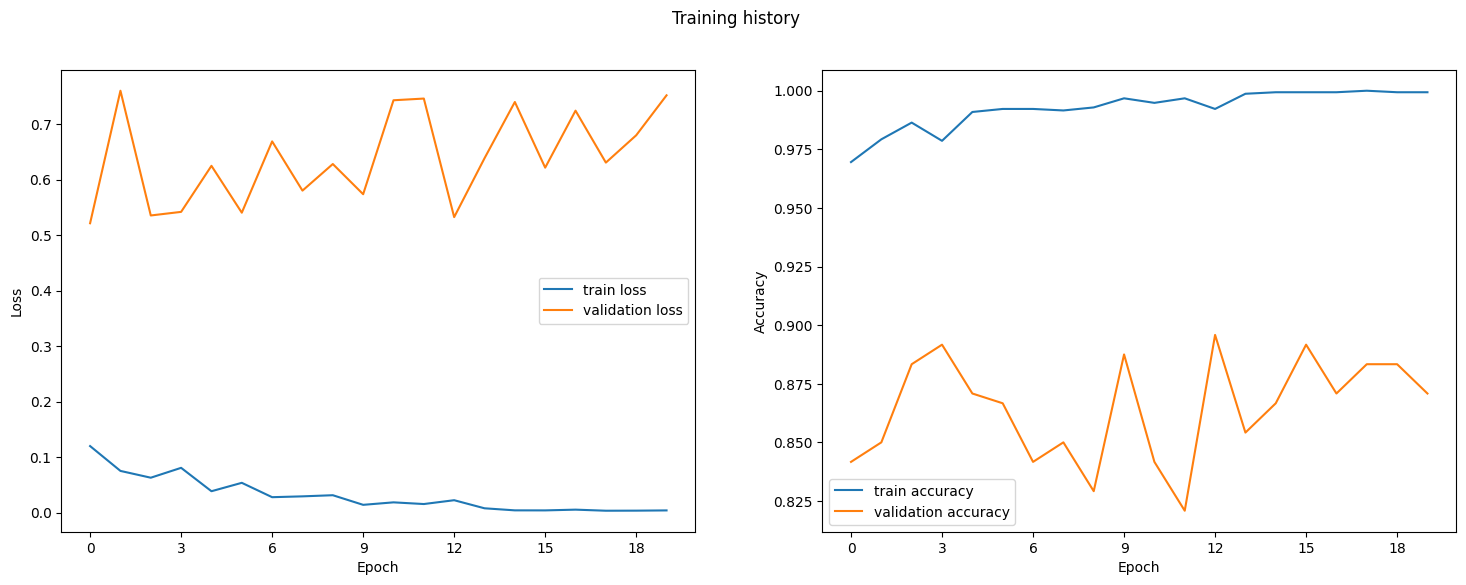

In [ ]:
base_model = my_model()
base_model = base_model.to(device)
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/inception_fold{fold}_newdata_seb_resprep_{dataset}_normalized{process}_cbam_add.bin'), strict= False)
torch.save(base_model.state_dict(), f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add_initialize.bin')
base_model, history = train_model(fold, base_model,loss_fn3,loss_fn4,loss_fn5,loss_fn6,(train_dataloader), val_dataloader, dataset_sizes, device)
plot_training_history(history)

  0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 37/37 [00:08<00:00,  4.50it/s]
<ipython-input-123-fddf8a4470dd>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'

[91, 93, 95, 97, 98, 99, 112, 114, 130, 133, 138, 148, 158, 161, 171, 247, 278, 281, 283, 286, 289, 292]
Accuracy: 0.9254237288135593
Specificity:  0.9152542372881356
Sensitivity:  0.940677966101695
F1 score: 0.9098360655737705
MCC score: 0.8476925736090474
AUC score: 0.9699320118739826
              precision    recall  f1-score     support
benign         0.958580  0.915254  0.936416  177.000000
malignant      0.880952  0.940678  0.909836  118.000000
accuracy       0.925424  0.925424  0.925424    0.925424
macro avg      0.919766  0.927966  0.923126  295.000000
weighted avg   0.927529  0.925424  0.925784  295.000000


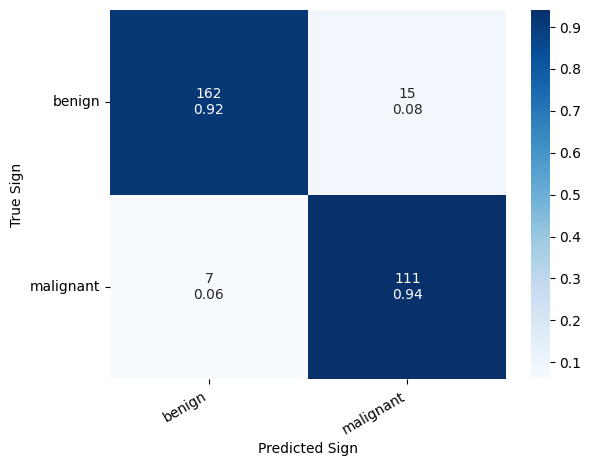

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc


class_names=['benign','malignant']
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
y_pred, y_test, y_pred01 = get_predictions(fold, base_model )
#print(y_pred01)
report=classification_report(y_test, y_pred, target_names=class_names,output_dict= True)
# print(classification_report(y_test, y_pred, target_names=class_names))

#specificity
cm = confusion_matrix(y_test, y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#Accuracy
acc= (TP+TN)/(TP+TN+FN+FP)
print("Accuracy:", acc)

#Sen
sp= TN/(TN+FP)
print('Specificity: ', sp )

#Spe
sn= TP/(TP+FN)
print('Sensitivity: ', sn )

#F_1
F1= (TP+TP)/(TP+TP+FN+FP)
print("F1 score:", F1)

#MCC
mcc = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
print("MCC score:", mcc)

#AUC
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)

metrics = metrics.append({'Fold': fold, 'Accuracy': acc, 'Sensitivity': sn, 'Specificity': sp, 'F-1 score': F1,
                'MCC': mcc, 'AUC': roc_auc}, ignore_index=True)


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'
model_name=f'8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add'
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')


# **Fold4**

tensor(1.)


tensor(1., dtype=torch.float64)


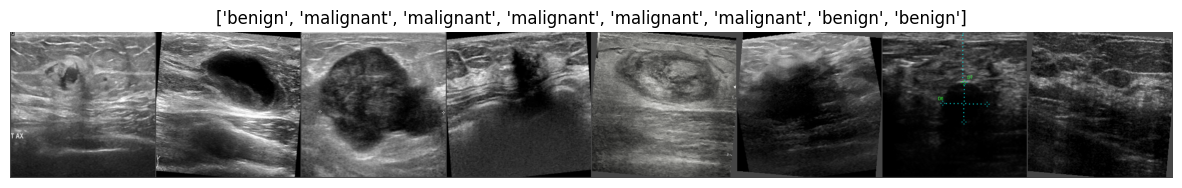

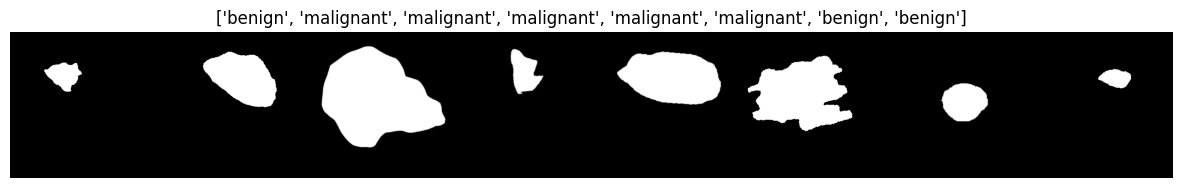

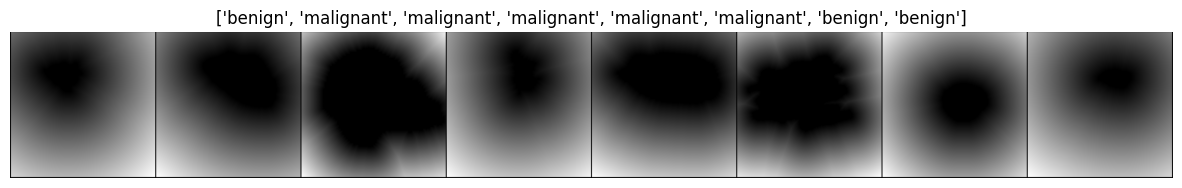

In [ ]:
fold=4
train_list_img, val_list_img, train_mask= get_list_train_val(fold)

train_dataset = MyDataset(train_list_img,us_features = df_fold4, train =True,  mask_path = train_mask,transforms =[transforms_dict['train'],transforms_dict['mask']])
train_dataloader = DataLoader(train_dataset,batch_size=8, shuffle = True, drop_last = True)

val_dataset = MyDataset(val_list_img,transforms=[transforms_dict['validation']])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


dataset_sizes = {'train' : len(train_dataset),'validation':len(val_dataset), 'mask' :len(train_dataset)}

inputs,classes,masks,dist_map,us_features = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
out1 = torchvision.utils.make_grid(masks)
imshow2(out1, title=[class_names[x] for x in classes])
out2 = torchvision.utils.make_grid(dist_map)
imshow2(out2, title=[class_names[x] for x in classes])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-d

tensor(0.0983, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  1%|          | 2/193 [00:16<24:33,  7.71s/it]

tensor(0.0742, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 3/193 [00:21<19:48,  6.25s/it]

tensor(0.0843, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 4/193 [00:24<16:19,  5.19s/it]

tensor(0.0856, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 5/193 [00:26<12:02,  3.84s/it]

tensor(0.1136, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  3%|▎         | 6/193 [00:30<11:50,  3.80s/it]

tensor(0.0945, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 7/193 [00:35<13:17,  4.29s/it]

tensor(0.0695, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▍         | 8/193 [00:37<11:13,  3.64s/it]

tensor(0.0973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▍         | 9/193 [00:41<11:46,  3.84s/it]

tensor(0.0797, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  5%|▌         | 10/193 [00:44<10:23,  3.41s/it]

tensor(0.0910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 11/193 [00:46<09:29,  3.13s/it]

tensor(0.0991, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  6%|▌         | 12/193 [00:49<09:21,  3.10s/it]

tensor(0.0940, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 13/193 [00:52<08:51,  2.96s/it]

tensor(0.1019, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  7%|▋         | 14/193 [00:55<08:58,  3.01s/it]

tensor(0.0976, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 15/193 [00:59<09:19,  3.14s/it]

tensor(0.0862, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  8%|▊         | 16/193 [01:02<09:13,  3.13s/it]

tensor(0.1011, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 17/193 [01:05<09:24,  3.20s/it]

tensor(0.0706, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


  9%|▉         | 18/193 [01:09<09:48,  3.36s/it]

tensor(0.0942, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|▉         | 19/193 [01:12<09:54,  3.42s/it]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 10%|█         | 20/193 [01:16<10:06,  3.50s/it]

tensor(0.0939, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█         | 21/193 [01:20<10:08,  3.54s/it]

tensor(0.0938, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 11%|█▏        | 22/193 [01:23<09:28,  3.33s/it]

tensor(0.0897, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 23/193 [01:26<09:12,  3.25s/it]

tensor(0.0887, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 12%|█▏        | 24/193 [01:30<10:04,  3.58s/it]

tensor(0.0760, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 25/193 [01:32<08:45,  3.13s/it]

tensor(0.1058, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 13%|█▎        | 26/193 [01:36<09:23,  3.37s/it]

tensor(0.0775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 14%|█▍        | 27/193 [01:39<09:02,  3.27s/it]

tensor(0.0937, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▍        | 28/193 [01:43<09:21,  3.41s/it]

tensor(0.0764, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 15%|█▌        | 29/193 [01:44<07:55,  2.90s/it]

tensor(0.0816, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 30/193 [01:47<07:15,  2.67s/it]

tensor(0.0957, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 16%|█▌        | 31/193 [01:50<07:43,  2.86s/it]

tensor(0.0823, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 32/193 [01:52<07:29,  2.79s/it]

tensor(0.1089, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 17%|█▋        | 33/193 [01:56<07:55,  2.97s/it]

tensor(0.0965, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 34/193 [01:59<08:18,  3.14s/it]

tensor(0.0869, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 18%|█▊        | 35/193 [02:04<09:20,  3.55s/it]

tensor(0.0750, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▊        | 36/193 [02:07<09:08,  3.49s/it]

tensor(0.0954, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 19%|█▉        | 37/193 [02:10<08:42,  3.35s/it]

tensor(0.0960, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|█▉        | 38/193 [02:14<08:33,  3.31s/it]

tensor(0.1007, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 20%|██        | 39/193 [02:16<07:42,  3.00s/it]

tensor(0.0932, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 40/193 [02:21<09:00,  3.53s/it]

tensor(0.0808, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 21%|██        | 41/193 [02:24<09:05,  3.59s/it]

tensor(0.1134, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 42/193 [02:27<08:31,  3.39s/it]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 22%|██▏       | 43/193 [02:31<08:34,  3.43s/it]

tensor(0.0772, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 44/193 [02:34<08:18,  3.35s/it]

tensor(0.0813, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 23%|██▎       | 45/193 [02:37<08:19,  3.37s/it]

tensor(0.0827, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 46/193 [02:44<10:31,  4.29s/it]

tensor(0.0786, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 24%|██▍       | 47/193 [02:46<09:06,  3.74s/it]

tensor(0.0734, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▍       | 48/193 [02:48<07:49,  3.24s/it]

tensor(0.0846, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 25%|██▌       | 49/193 [02:51<07:38,  3.19s/it]

tensor(0.0771, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▌       | 50/193 [02:54<07:19,  3.07s/it]

tensor(0.1149, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 26%|██▋       | 51/193 [02:59<08:28,  3.58s/it]

tensor(0.0745, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 52/193 [03:03<08:31,  3.63s/it]

tensor(0.0694, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 27%|██▋       | 53/193 [03:06<08:27,  3.62s/it]

tensor(0.1003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 54/193 [03:09<07:55,  3.42s/it]

tensor(0.0840, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 28%|██▊       | 55/193 [03:12<07:35,  3.30s/it]

tensor(0.0981, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 29%|██▉       | 56/193 [03:16<08:01,  3.52s/it]

tensor(0.0843, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|██▉       | 57/193 [03:20<08:27,  3.73s/it]

tensor(0.1126, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 30%|███       | 58/193 [03:23<07:49,  3.48s/it]

tensor(0.0903, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 59/193 [03:26<07:30,  3.36s/it]

tensor(0.0965, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 31%|███       | 60/193 [03:29<07:10,  3.23s/it]

tensor(0.0951, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 61/193 [03:33<07:31,  3.42s/it]

tensor(0.0642, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 32%|███▏      | 62/193 [03:38<08:30,  3.90s/it]

tensor(0.0609, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 63/193 [03:41<07:44,  3.57s/it]

tensor(0.0972, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 33%|███▎      | 64/193 [03:43<06:25,  2.99s/it]

tensor(0.0948, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▎      | 65/193 [03:46<06:52,  3.23s/it]

tensor(0.0795, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 34%|███▍      | 66/193 [03:51<07:35,  3.58s/it]

tensor(0.0842, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▍      | 67/193 [03:55<07:35,  3.62s/it]

tensor(0.0900, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 35%|███▌      | 68/193 [03:58<07:37,  3.66s/it]

tensor(0.0963, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▌      | 69/193 [04:01<07:09,  3.46s/it]

tensor(0.0853, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 36%|███▋      | 70/193 [04:04<06:38,  3.24s/it]

tensor(0.0884, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 71/193 [04:08<07:14,  3.56s/it]

tensor(0.0962, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 37%|███▋      | 72/193 [04:12<07:03,  3.50s/it]

tensor(0.0875, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 73/193 [04:16<07:39,  3.83s/it]

tensor(0.0852, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 38%|███▊      | 74/193 [04:20<07:17,  3.67s/it]

tensor(0.1052, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 75/193 [04:23<07:12,  3.67s/it]

tensor(0.0886, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 39%|███▉      | 76/193 [04:26<06:52,  3.52s/it]

tensor(0.0927, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|███▉      | 77/193 [04:30<06:59,  3.62s/it]

tensor(0.0864, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 40%|████      | 78/193 [04:32<05:44,  2.99s/it]

tensor(0.0805, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████      | 79/193 [04:36<06:34,  3.46s/it]

tensor(0.0919, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 41%|████▏     | 80/193 [04:40<06:43,  3.57s/it]

tensor(0.0661, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 81/193 [04:43<06:13,  3.33s/it]

tensor(0.0815, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 42%|████▏     | 82/193 [04:46<06:10,  3.33s/it]

tensor(0.0820, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 43%|████▎     | 83/193 [04:49<05:52,  3.20s/it]

tensor(0.0893, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▎     | 84/193 [04:54<06:51,  3.78s/it]

tensor(0.0810, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 44%|████▍     | 85/193 [04:57<06:25,  3.57s/it]

tensor(0.0809, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▍     | 86/193 [05:01<06:15,  3.51s/it]

tensor(0.1019, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 45%|████▌     | 87/193 [05:05<06:25,  3.64s/it]

tensor(0.0854, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 88/193 [05:08<06:08,  3.51s/it]

tensor(0.0919, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 46%|████▌     | 89/193 [05:12<06:10,  3.56s/it]

tensor(0.0702, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 90/193 [05:15<06:01,  3.51s/it]

tensor(0.0844, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 47%|████▋     | 91/193 [05:20<06:45,  3.97s/it]

tensor(0.0728, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 92/193 [05:25<07:08,  4.24s/it]

tensor(0.0720, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 48%|████▊     | 93/193 [05:28<06:22,  3.82s/it]

tensor(0.0936, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▊     | 94/193 [05:32<06:15,  3.79s/it]

tensor(0.0801, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 49%|████▉     | 95/193 [05:36<06:45,  4.14s/it]

tensor(0.0817, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|████▉     | 96/193 [05:41<06:49,  4.22s/it]

tensor(0.0748, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 50%|█████     | 97/193 [05:44<06:04,  3.80s/it]

tensor(0.0954, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████     | 98/193 [05:47<05:47,  3.65s/it]

tensor(0.0906, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 51%|█████▏    | 99/193 [05:52<06:23,  4.07s/it]

tensor(0.0758, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 100/193 [05:54<05:27,  3.52s/it]

tensor(0.0803, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 52%|█████▏    | 101/193 [05:57<04:53,  3.19s/it]

tensor(0.0800, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 102/193 [06:01<05:08,  3.39s/it]

tensor(0.0819, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 53%|█████▎    | 103/193 [06:04<05:01,  3.35s/it]

tensor(0.0917, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 104/193 [06:07<05:01,  3.39s/it]

tensor(0.0822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 54%|█████▍    | 105/193 [06:11<04:54,  3.35s/it]

tensor(0.0893, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▍    | 106/193 [06:13<04:20,  3.00s/it]

tensor(0.0884, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 55%|█████▌    | 107/193 [06:16<04:20,  3.03s/it]

tensor(0.0751, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▌    | 108/193 [06:19<04:18,  3.04s/it]

tensor(0.0832, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 56%|█████▋    | 109/193 [06:23<04:43,  3.38s/it]

tensor(0.0726, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 57%|█████▋    | 110/193 [06:28<05:23,  3.90s/it]

tensor(0.1069, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 111/193 [06:31<04:59,  3.65s/it]

tensor(0.1041, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 58%|█████▊    | 112/193 [06:35<04:46,  3.53s/it]

tensor(0.0973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▊    | 113/193 [06:39<05:03,  3.80s/it]

tensor(0.0697, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 59%|█████▉    | 114/193 [06:44<05:25,  4.12s/it]

tensor(0.0700, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|█████▉    | 115/193 [06:47<04:48,  3.70s/it]

tensor(0.0867, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 60%|██████    | 116/193 [06:49<04:13,  3.29s/it]

tensor(0.1073, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 117/193 [06:52<04:09,  3.28s/it]

tensor(0.0953, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 61%|██████    | 118/193 [06:55<04:00,  3.21s/it]

tensor(0.0963, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 119/193 [06:57<03:36,  2.93s/it]

tensor(0.0839, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 62%|██████▏   | 120/193 [07:02<04:03,  3.34s/it]

tensor(0.0798, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 121/193 [07:07<04:32,  3.78s/it]

tensor(0.0875, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 63%|██████▎   | 122/193 [07:10<04:26,  3.76s/it]

tensor(0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▎   | 123/193 [07:15<04:51,  4.16s/it]

tensor(0.0678, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 64%|██████▍   | 124/193 [07:20<04:57,  4.31s/it]

tensor(0.0985, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▍   | 125/193 [07:23<04:32,  4.01s/it]

tensor(0.0746, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 65%|██████▌   | 126/193 [07:29<04:53,  4.38s/it]

tensor(0.0770, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▌   | 127/193 [07:34<05:01,  4.57s/it]

tensor(0.0930, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 66%|██████▋   | 128/193 [07:36<04:12,  3.88s/it]

tensor(0.1083, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 129/193 [07:39<03:50,  3.59s/it]

tensor(0.0828, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 67%|██████▋   | 130/193 [07:42<03:39,  3.49s/it]

tensor(0.0787, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 131/193 [07:46<03:40,  3.56s/it]

tensor(0.0877, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 68%|██████▊   | 132/193 [07:48<03:13,  3.18s/it]

tensor(0.1057, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 133/193 [07:51<03:14,  3.25s/it]

tensor(0.0919, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 69%|██████▉   | 134/193 [07:53<02:46,  2.82s/it]

tensor(0.0819, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|██████▉   | 135/193 [07:59<03:35,  3.71s/it]

tensor(0.0765, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 70%|███████   | 136/193 [08:03<03:27,  3.64s/it]

tensor(0.0908, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 71%|███████   | 137/193 [08:06<03:26,  3.69s/it]

tensor(0.1028, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 138/193 [08:10<03:24,  3.72s/it]

tensor(0.0926, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 72%|███████▏  | 139/193 [08:13<03:05,  3.43s/it]

tensor(0.1014, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 140/193 [08:16<02:59,  3.39s/it]

tensor(0.0882, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 73%|███████▎  | 141/193 [08:20<02:58,  3.43s/it]

tensor(0.0993, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▎  | 142/193 [08:25<03:16,  3.84s/it]

tensor(0.0835, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 74%|███████▍  | 143/193 [08:28<03:12,  3.85s/it]

tensor(0.0833, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▍  | 144/193 [08:32<03:04,  3.77s/it]

tensor(0.0914, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 75%|███████▌  | 145/193 [08:35<02:49,  3.54s/it]

tensor(0.0769, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 146/193 [08:37<02:23,  3.05s/it]

tensor(0.0881, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 76%|███████▌  | 147/193 [08:41<02:34,  3.36s/it]

tensor(0.0945, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 148/193 [08:43<02:10,  2.91s/it]

tensor(0.0894, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 77%|███████▋  | 149/193 [08:46<02:17,  3.13s/it]

tensor(0.0882, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 150/193 [08:50<02:16,  3.17s/it]

tensor(0.0806, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 78%|███████▊  | 151/193 [08:55<02:37,  3.74s/it]

tensor(0.0887, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 152/193 [08:58<02:23,  3.51s/it]

tensor(0.0812, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 79%|███████▉  | 153/193 [09:01<02:11,  3.29s/it]

tensor(0.0918, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|███████▉  | 154/193 [09:04<02:12,  3.40s/it]

tensor(0.0905, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 80%|████████  | 155/193 [09:07<02:00,  3.18s/it]

tensor(0.0946, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████  | 156/193 [09:10<02:01,  3.28s/it]

tensor(0.0845, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 81%|████████▏ | 157/193 [09:15<02:17,  3.83s/it]

tensor(0.0639, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 158/193 [09:19<02:14,  3.83s/it]

tensor(0.0910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 82%|████████▏ | 159/193 [09:23<02:06,  3.73s/it]

tensor(0.0952, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 160/193 [09:25<01:47,  3.25s/it]

tensor(0.0885, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 83%|████████▎ | 161/193 [09:29<01:50,  3.44s/it]

tensor(0.0913, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 162/193 [09:32<01:47,  3.46s/it]

tensor(0.0982, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 84%|████████▍ | 163/193 [09:37<01:50,  3.68s/it]

tensor(0.0775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▍ | 164/193 [09:40<01:46,  3.66s/it]

tensor(0.0717, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 85%|████████▌ | 165/193 [09:44<01:46,  3.80s/it]

tensor(0.0728, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 86%|████████▌ | 166/193 [09:47<01:36,  3.57s/it]

tensor(0.1019, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 167/193 [09:51<01:34,  3.62s/it]

tensor(0.1119, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 87%|████████▋ | 168/193 [09:55<01:35,  3.81s/it]

tensor(0.0889, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 169/193 [09:59<01:27,  3.64s/it]

tensor(0.0930, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 88%|████████▊ | 170/193 [10:03<01:26,  3.77s/it]

tensor(0.0672, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▊ | 171/193 [10:06<01:19,  3.61s/it]

tensor(0.0954, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 89%|████████▉ | 172/193 [10:09<01:12,  3.47s/it]

tensor(0.0869, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|████████▉ | 173/193 [10:13<01:11,  3.57s/it]

tensor(0.0817, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 90%|█████████ | 174/193 [10:18<01:16,  4.01s/it]

tensor(0.1002, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 175/193 [10:21<01:08,  3.78s/it]

tensor(0.0868, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 91%|█████████ | 176/193 [10:25<01:05,  3.85s/it]

tensor(0.0678, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 177/193 [10:29<01:01,  3.83s/it]

tensor(0.1125, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 92%|█████████▏| 178/193 [10:33<00:57,  3.81s/it]

tensor(0.0961, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 179/193 [10:37<00:53,  3.85s/it]

tensor(0.0999, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 93%|█████████▎| 180/193 [10:40<00:49,  3.78s/it]

tensor(0.0807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 181/193 [10:43<00:43,  3.58s/it]

tensor(0.0854, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 94%|█████████▍| 182/193 [10:46<00:37,  3.38s/it]

tensor(0.0856, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▍| 183/193 [10:50<00:35,  3.58s/it]

tensor(0.0919, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 95%|█████████▌| 184/193 [10:54<00:32,  3.60s/it]

tensor(0.0862, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▌| 185/193 [10:56<00:25,  3.22s/it]

tensor(0.0900, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 96%|█████████▋| 186/193 [10:59<00:22,  3.16s/it]

tensor(0.1042, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 187/193 [11:02<00:18,  3.08s/it]

tensor(0.1126, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 97%|█████████▋| 188/193 [11:07<00:18,  3.70s/it]

tensor(0.0713, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 189/193 [11:10<00:14,  3.52s/it]

tensor(0.0748, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 98%|█████████▊| 190/193 [11:15<00:11,  3.81s/it]

tensor(0.0623, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 191/193 [11:20<00:08,  4.23s/it]

tensor(0.0645, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


 99%|█████████▉| 192/193 [11:23<00:03,  3.91s/it]

tensor(0.0846, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


100%|██████████| 193/193 [11:27<00:00,  3.56s/it]


tensor(0.0804, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 1/20
----------


100%|██████████| 193/193 [01:45<00:00,  1.83it/s]


Train loss -1.0900047814210558 accuracy 0.9721502590673575 boundary_loss-4.919032042082468 iou_loss2 -0.8729689630819726 iou_loss1 -0.3102021879019515 nbrloss 0.15025112083075579 feature_loss 0.04490348190995696 crossentropyloss 0.09589528915925624
Val   loss 0.41714289331616 accuracy 0.8663793103448276

Epoch 2/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -1.661187917081871 accuracy 0.9876943005181347 boundary_loss-7.4478785589942955 iou_loss2 -0.8963477750516309 iou_loss1 -0.38144630348126507 nbrloss 0.13828832930233811 feature_loss 0.039772530670224696 crossentropyloss 0.05231169545829991
Val   loss 0.4762137359778943 accuracy 0.8706896551724138

Epoch 3/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -1.8571339709576578 accuracy 0.9909326424870466 boundary_loss-8.320306437137537 iou_loss2 -0.9054992310123741 iou_loss1 -0.41458575589669183 nbrloss 0.13217616123702242 feature_loss 0.03910299493337697 crossentropyloss 0.04059878568686159
Val   loss 0.4467602577060461 accuracy 0.8879310344827587

Epoch 4/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -1.9384242326418508 accuracy 0.9870466321243523 boundary_loss-8.761767174880507 iou_loss2 -0.9100794403046524 iou_loss1 -0.4309416624857354 nbrloss 0.12971269980150182 feature_loss 0.03816131674177906 crossentropyloss 0.05237475594860342
Val   loss 0.3356865878249037 accuracy 0.8663793103448276

Epoch 5/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.061078389086671 accuracy 0.9935233160621761 boundary_loss-9.223142005374008 iou_loss2 -0.9143905852742763 iou_loss1 -0.44999508490216544 nbrloss 0.12742777678324152 feature_loss 0.037225214359133355 crossentropyloss 0.027219072690021266
Val   loss 0.665264959822425 accuracy 0.8706896551724138

Epoch 6/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.122753274456223 accuracy 0.9902849740932642 boundary_loss-9.574896000518777 iou_loss2 -0.9178047661954257 iou_loss1 -0.4627651397737197 nbrloss 0.12657338257280656 feature_loss 0.037174859668075114 crossentropyloss 0.0393077485254903
Val   loss 0.5800912171473791 accuracy 0.853448275862069

Epoch 7/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.1935855735333223 accuracy 0.9967616580310881 boundary_loss-9.77645537177503 iou_loss2 -0.9208164455977128 iou_loss1 -0.47440273681452855 nbrloss 0.12452419835668771 feature_loss 0.03687142739024187 crossentropyloss 0.012157358084847534
Val   loss 1.0771984589077404 accuracy 0.8491379310344828

Epoch 00007: reducing learning rate of group 0 to 8.0000e-05.
Epoch 8/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.168971023283465 accuracy 0.9883419689119171 boundary_loss-9.867164801572223 iou_loss2 -0.9210114059052936 iou_loss1 -0.47707137774309344 nbrloss 0.12558481297962407 feature_loss 0.03668084402853343 crossentropyloss 0.05529345073037506
Val   loss 0.4667256476903527 accuracy 0.8620689655172413

Epoch 9/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.249688023837973 accuracy 0.9948186528497409 boundary_loss-10.10144710401606 iou_loss2 -0.9237202918591277 iou_loss1 -0.48788644056863734 nbrloss 0.1222101571569171 feature_loss 0.03630194422147126 crossentropyloss 0.024850522279268893
Val   loss 0.47901101870430185 accuracy 0.8879310344827587

Epoch 10/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.2798988626924652 accuracy 0.9948186528497409 boundary_loss-10.185232983222813 iou_loss2 -0.9248186034859771 iou_loss1 -0.4926079729369267 nbrloss 0.12244729022133535 feature_loss 0.036226454683111434 crossentropyloss 0.012520950397059147
Val   loss 0.6963279102959044 accuracy 0.8620689655172413

Epoch 00010: reducing learning rate of group 0 to 6.4000e-05.
Epoch 11/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.304698935408749 accuracy 0.9954663212435233 boundary_loss-10.299618861078084 iou_loss2 -0.9262789944910632 iou_loss1 -0.49880428326562276 nbrloss 0.12063759013315556 feature_loss 0.03598133927220817 crossentropyloss 0.012515844875018334
Val   loss 0.39971256139688194 accuracy 0.8879310344827587

Epoch 12/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.3085686313800102 accuracy 0.9941709844559585 boundary_loss-10.360746390949187 iou_loss2 -0.9266395843708454 iou_loss1 -0.5001491871831331 nbrloss 0.12107683274257985 feature_loss 0.03583710166804222 crossentropyloss 0.02113932709588423
Val   loss 0.44516194517852675 accuracy 0.9094827586206896

Epoch 13/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.87it/s]


Train loss -2.30929871951022 accuracy 0.9928756476683938 boundary_loss-10.365481027735406 iou_loss2 -0.9271432630756359 iou_loss1 -0.5008354031051379 nbrloss 0.1220778117602971 feature_loss 0.03600488234446456 crossentropyloss 0.02137717264469163
Val   loss 0.5098347379906296 accuracy 0.8836206896551724

Epoch 00013: reducing learning rate of group 0 to 5.1200e-05.
Epoch 14/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.87it/s]


Train loss -2.3315397408375165 accuracy 0.9961139896373057 boundary_loss-10.441679676403192 iou_loss2 -0.9275090558541254 iou_loss1 -0.5044707248247967 nbrloss 0.12085383149935174 feature_loss 0.03558136064346899 crossentropyloss 0.01546325252817852
Val   loss 0.46416715050822704 accuracy 0.8922413793103449

Epoch 15/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.341382331854612 accuracy 0.9948186528497409 boundary_loss-10.505489897783466 iou_loss2 -0.9281508181379249 iou_loss1 -0.5076394011628442 nbrloss 0.1214385344960529 feature_loss 0.035605271790813596 crossentropyloss 0.019025461865260888
Val   loss 0.4147989564105579 accuracy 0.875

Epoch 16/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.89it/s]


Train loss -2.3538791151020897 accuracy 0.9961139896373057 boundary_loss-10.545898223174403 iou_loss2 -0.9284771606712143 iou_loss1 -0.5089782422379509 nbrloss 0.12101393613790601 feature_loss 0.0353198009277718 crossentropyloss 0.01505684700099042
Val   loss 0.3866125419575336 accuracy 0.8793103448275862

Epoch 00016: reducing learning rate of group 0 to 4.0960e-05.
Epoch 17/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.37855761278319 accuracy 1.0 boundary_loss-10.605379074356149 iou_loss2 -0.9296410568637551 iou_loss1 -0.5127134789456975 nbrloss 0.12114101578843409 feature_loss 0.03456738336407459 crossentropyloss 0.0033041722576406547
Val   loss 0.4543077128393383 accuracy 0.875

Epoch 18/20
----------


100%|██████████| 193/193 [01:42<00:00,  1.88it/s]


Train loss -2.389347128222471 accuracy 1.0 boundary_loss-10.653473226439523 iou_loss2 -0.9296235510104679 iou_loss1 -0.5144921257088222 nbrloss 0.12059023540100286 feature_loss 0.03527983910177347 crossentropyloss 0.0025246259117760778
Val   loss 0.6262942681225531 accuracy 0.8706896551724138

Epoch 19/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.3920246219347945 accuracy 1.0 boundary_loss-10.663241729506318 iou_loss2 -0.9300838498871561 iou_loss1 -0.5163667217437468 nbrloss 0.12063621517290106 feature_loss 0.035046450277414036 crossentropyloss 0.0022819541621509304
Val   loss 0.6282922367079601 accuracy 0.8793103448275862

Epoch 00019: reducing learning rate of group 0 to 3.2768e-05.
Epoch 20/20
----------


100%|██████████| 193/193 [01:43<00:00,  1.86it/s]


Train loss -2.4059613463757272 accuracy 1.0 boundary_loss-10.728861490816499 iou_loss2 -0.9307050235530873 iou_loss1 -0.5184022032226305 nbrloss 0.11982319283979545 feature_loss 0.03504615838258223 crossentropyloss 0.00216314729812514
Val   loss 0.5732265389323684 accuracy 0.875



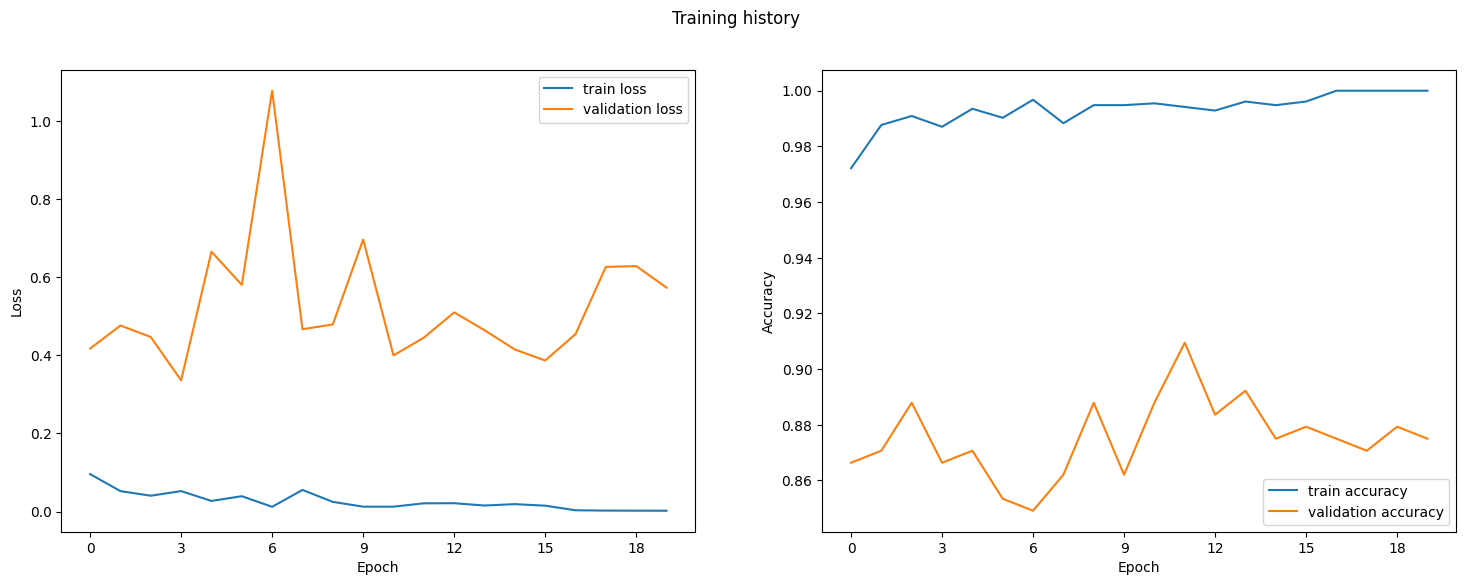

In [ ]:
base_model = my_model()
base_model = base_model.to(device)

base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/inception_fold{fold}_newdata_seb_resprep_{dataset}_normalized{process}_cbam_add.bin'), strict= False)

base_model, history = train_model(fold, base_model, loss_fn3,loss_fn4,loss_fn5,loss_fn6,(train_dataloader), val_dataloader, dataset_sizes, device)
plot_training_history(history)

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc


class_names=['benign','malignant']
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
y_pred, y_test, y_pred01 = get_predictions(fold, base_model )
#print(y_pred01)
report=classification_report(y_test, y_pred, target_names=class_names,output_dict= True)
# print(classification_report(y_test, y_pred, target_names=class_names))

#specificity
cm = confusion_matrix(y_test, y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#Accuracy
acc= (TP+TN)/(TP+TN+FN+FP)
print("Accuracy:", acc)

#Sen
sp= TN/(TN+FP)
print('Specificity: ', sp )

#Spe
sn= TP/(TP+FN)
print('Sensitivity: ', sn )

#F_1
F1= (TP+TP)/(TP+TP+FN+FP)
print("F1 score:", F1)

#MCC
mcc = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
print("MCC score:", mcc)

#AUC
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)

metrics = metrics.append({'Fold': fold, 'Accuracy': acc, 'Sensitivity': sn, 'Specificity': sp, 'F-1 score': F1,
                'MCC': mcc, 'AUC': roc_auc}, ignore_index=True)


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'
model_name=f'8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add'
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')


# **Fold5**

tensor(1.)
tensor(1., dtype=torch.float64)


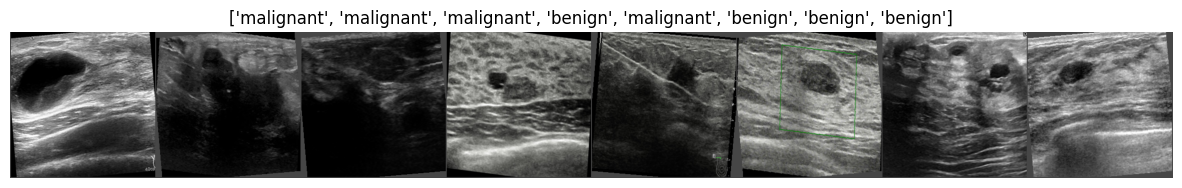

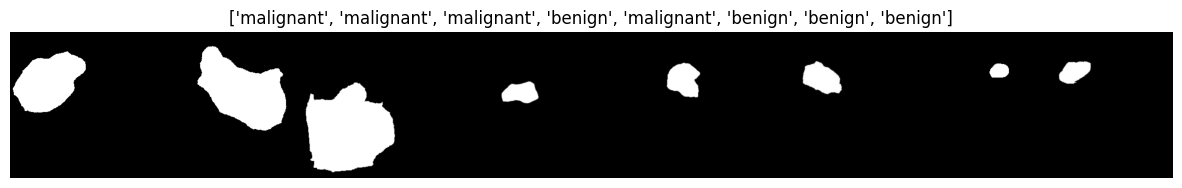

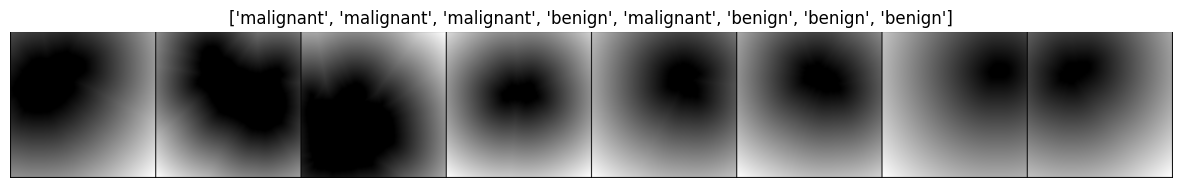

In [ ]:
fold=5
train_list_img, val_list_img, train_mask= get_list_train_val(fold)

train_dataset = MyDataset(train_list_img,us_features = df_fold5, train =True,  mask_path = train_mask,transforms =[transforms_dict['train'],transforms_dict['mask']])
train_dataloader = DataLoader(train_dataset,batch_size=8, shuffle = True, drop_last = True)

val_dataset = MyDataset(val_list_img,transforms=[transforms_dict['validation']])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


dataset_sizes = {'train' : len(train_dataset),'validation':len(val_dataset), 'mask' :len(train_dataset)}

inputs,classes,masks,dist_map,us_features = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
out1 = torchvision.utils.make_grid(masks)
imshow2(out1, title=[class_names[x] for x in classes])
out2 = torchvision.utils.make_grid(dist_map)
imshow2(out2, title=[class_names[x] for x in classes])

In [ ]:
base_model = my_model()
base_model = base_model.to(device)

base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/inception_fold{fold}_newdata_seb_resprep_{dataset}_normalized{process}_cbam_add.bin'), strict= False)

base_model, history = train_model(fold, base_model, loss_fn3,loss_fn4,loss_fn5,loss_fn6,(train_dataloader), val_dataloader, dataset_sizes, device)
plot_training_history(history)

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc


class_names=['benign','malignant']
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add2.bin'))
y_pred, y_test, y_pred01 = get_predictions(fold, base_model )
#print(y_pred01)
report=classification_report(y_test, y_pred, target_names=class_names,output_dict= True)
# print(classification_report(y_test, y_pred, target_names=class_names))

#specificity
cm = confusion_matrix(y_test, y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#Accuracy
acc= (TP+TN)/(TP+TN+FN+FP)
print("Accuracy:", acc)

#Sen
sp= TN/(TN+FP)
print('Specificity: ', sp )

#Spe
sn= TP/(TP+FN)
print('Sensitivity: ', sn )

#F_1
F1= (TP+TP)/(TP+TP+FN+FP)
print("F1 score:", F1)

#MCC
mcc = (TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5)
print("MCC score:", mcc)

#AUC
y_pred01_cpu = [tensor.cpu().numpy().item() for tensor in y_pred01]
y_test_cpu = [tensor.cpu().numpy().item() for tensor in y_test]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cpu, y_pred01_cpu)
roc_auc = auc(false_positive_rate, true_positive_rate)
auc_score = roc_auc_score(y_test_cpu, y_pred01_cpu)
print("AUC score:", roc_auc)

metrics = metrics.append({'Fold': fold, 'Accuracy': acc, 'Sensitivity': sn, 'Specificity': sp, 'F-1 score': F1,
                'MCC': mcc, 'AUC': roc_auc}, ignore_index=True)


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'
model_name=f'8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add'
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')


In [ ]:
metrics


In [ ]:
%tensorboard --logdir=runs

Launching TensorBoard...

# **Visualizing Preprocessor Output**

In [ ]:
fold = 1

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18

#base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add2.bin'))
base_model.eval()

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  #inp=inp[:,:,2]

  plt.figure(figsize = (21,8))
  plt.imshow(inp, cmap='gray')
  if title is not None:
    plt.title(title)
  plt.axis('off')

test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

inputs, classes, masks = next(iter(test_dataloader))
outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(inputs.to(device))
print(prep_out.shape)
out = torchvision.utils.make_grid(inputs)
out2 = torchvision.utils.make_grid(prep_out.cpu())

imshow(out, title=[class_names[x] for x in classes])
imshow(out2, title=[class_names[x] for x in classes])

# **Visualizing CAM**

In [ ]:
fold=2

In [ ]:
def tensor2img(tensor, ax=plt):
    tensor = tensor.squeeze()
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    img = tensor.detach().cpu().numpy()
    return img

def subplot(images, parse=lambda x: x, rows_titles=None, cols_titles=None, title='', *args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    fig.suptitle(title)
    i = 0
    try:
        for row in ax:
            if rows_titles is not None: row.set_title(rows_titles[i])
            try:
                for j, col in enumerate(row):
                    if cols_titles is not None:  col.set_title(cols_titles[j])
                    col.imshow(parse(images[i]))
                    col.axis('off')
                    col.set_aspect('equal')
                    i += 1
            except TypeError:
                row.imshow(parse(images[i]))
                row.axis('off')
                row.set_aspect('equal')
                i += 1
            except IndexError:
                break

    except:
        ax.imshow(parse(images[i]))
        ax.axis('off')
        ax.set_aspect('equal')

        fig.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        plt.show()


def module2traced(module, inputs):
    handles, modules = [], []

    def trace(module, inputs, outputs):
        modules.append(module)

    def traverse(module):
        for m in module.children():
            traverse(m)  # recursion is love
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))

    traverse(module)

    _ = module(inputs)

    [h.remove() for h in handles]

    return modules

def run_vis_plot(vis, x, layer, ncols=1, nrows=1):
    images, info = vis(x, layer)
    images = images[: nrows*ncols]
    print(images[0].shape)
    subplot(images, tensor2img, title=str(layer), ncols=ncols, nrows=nrows)

def run_vis_plot_across_models(modules, input, layer_id, Vis, title,
                               device,
                               inputs=None,
                               nrows=3,
                               ncols=2,
                               row_wise=True,
                               parse=tensor2img,
                               annotations=None,
                               idx2label=None,
                               rows_name=None,*args, **kwargs):
    pad = 0 # in points
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle(title)

    for i, row in enumerate(ax):
        try:
            module = next(modules)
            module.eval()
            module = module.to(device)
            layer = None
            if layer_id is not None: layer = module2traced(module, input)[layer_id]
            vis = Vis(module, device)
            info = {}
            if inputs is None: images, info = vis(input.clone(), layer, *args, **kwargs)
            row_title = module.__class__.__name__
            del module
            torch.cuda.empty_cache()
            if rows_name is not None: row_title = rows_name[i]
            row[0].set_title(row_title)
            if annotations is not None:
                row[0].annotate(annotations[i], xy=(0, 0.5), xytext=(-row[0].yaxis.labelpad - pad, 0),
                    xycoords=row[0].yaxis.label, textcoords='offset points',
                    size='medium', ha='right', va='center', rotation=90)
            for j, col in enumerate(row):
                if inputs is None: image = images[j]
                else: image, info = vis(inputs[j], layer, *args, **kwargs)
                if 'prediction' in info: col.set_title(idx2label[int(info['prediction'])])
                col.imshow(parse(image))
                col.axis('off')
                col.set_aspect('equal')
        except StopIteration:
            break
        except:
            row.set_title(row_title)
            row.imshow(parse(images[0]))
            row.axis('off')
            row.set_aspect('equal')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

In [ ]:
import torch
import numpy as np
import cv2

from torchvision.transforms import Compose, Normalize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

image_net_mean = torch.Tensor([0.275, 0.275, 0.275])
image_net_std = torch.Tensor([0.197, 0.197, 0.197])

import matplotlib.pyplot as plt

class NormalizeInverse(Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """
    def __init__(self, mean, std):
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

image_net_preprocessing = Compose([
    Normalize(
        mean=image_net_mean,
        std=image_net_std
    )
])

image_net_postprocessing = Compose([
    NormalizeInverse(
        mean=image_net_mean,
        std=image_net_std)
])

def tensor2cam(image, cam):
    image_with_heatmap = image2cam(image.squeeze().permute(1,2,0).cpu().numpy(),
              cam.permute(1,2,0).detach().cpu().numpy())

    return torch.from_numpy(image_with_heatmap).permute(2,0,1)

def image2cam(image, cam):
    h, w, c = image.shape
    #cam -= np.min(cam)
    # Normalize between 0-1
    #cam = cv2.resize(cam, (w,h))
    #cam /= np.max(cam)
    #print(np.max(cam))

    cam = np.uint8(cam * 255.0)
    #print(dtype.cam)
    img_with_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    #print(img_with_cam.shape)
    img_with_cam = cv2.cvtColor(img_with_cam, cv2.COLOR_BGR2RGB)
    img_with_cam = img_with_cam + (image * 255)
    img_with_cam /= np.max(img_with_cam)

    return img_with_cam

def process_cam(image,cam):
    h, w, c = image.shape
    cam -= np.min(cam)
    # Normalize between 0-1
    cam = cv2.resize(cam, (w,h))
    cam /= np.max(cam)
    print(np.max(cam))
    print(cam.shape)

    cam = np.uint8(cam * 255.0)
    img_with_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    #img_with_cam = cv2.cvtColor(img_with_cam, cv2.COLOR_BGR2RGB
    #img_with_cam /= np.max(img_with_cam)

    return torch.from_numpy(img_with_cam).permute(2,0,1)

def convert_to_grayscale(cv2im):
    """
        Converts 3d image to grayscale
    Args:
        cv2im (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    credits to https://github.com/utkuozbulak/pytorch-cnn-visualizations
    """
    grayscale_im = np.sum(np.abs(cv2im), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

def imshow(tensor):
    tensor = tensor.squeeze()
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    img = tensor.cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

def module2traced(module, inputs):
    handles, modules = [], []

    def trace(module, inputs, outputs):
        modules.append(module)

    def traverse(module):
        for m in module.children():
            traverse(m)
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))

    traverse(module)

    #_ = module(inputs)

    [h.remove() for h in handles]

    return modules


In [ ]:
path= '/content/drive/My Drive/Final_Results/cam'

In [ ]:
fold = 1
process=2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])

In [ ]:
#printing CAM for benign images
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(90,6, figsize=(26,350))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 0:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: benign'.format(prediction))
        i+=1

plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap.png', bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
#printing CAM for malignant images
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(60,6, figsize=(26,250))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 1:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: malignant'.format(prediction))
        i+=1
plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap2.png', bbox_inches='tight')

In [ ]:
fold = 2
process=2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(90,6, figsize=(26,350))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 0:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: benign'.format(prediction))
        i+=1

plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap.png', bbox_inches='tight')

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(60,6, figsize=(26,250))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 1:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: malignant'.format(prediction))
        i+=1
plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap2.png', bbox_inches='tight')

In [ ]:
fold = 3
process=2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(90,6, figsize=(26,350))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 0:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: benign'.format(prediction))
        i+=1

plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap.png', bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(60,6, figsize=(26,250))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 1:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: malignant'.format(prediction))
        i+=1
plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap2.png', bbox_inches='tight')

In [ ]:
fold = 4
process=2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(90,6, figsize=(26,350))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 0:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: benign'.format(prediction))
        i+=1

plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap.png', bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(60,6, figsize=(26,250))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 1:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: malignant'.format(prediction))
        i+=1
plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap2.png', bbox_inches='tight')

In [ ]:
fold = 5
process=2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
test_list_img, test_mask = get_list_test(fold)
test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(90,6, figsize=(26,350))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 0:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: benign'.format(prediction))
        i+=1

plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap.png', bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
#from torchcam.cams import GradCAM
import matplotlib.pyplot as plt
#from torchcam.utils import overlay_mask
from PIL import Image

mean_nums = [0.275, 0.275, 0.275]
std_nums = [0.197, 0.197, 0.197]

normalize_inverse = NormalizeInverse(mean_nums, std_nums)
ig, ax = plt.subplots(60,6, figsize=(26,250))
ax = ax.ravel()

#plt.tight_layout()
#os.chdir(data_dir+'/test/benign/')
data_dir = f'/content/drive/My Drive/{dataset}/Fold{fold}{fold}'
data_dir2 = f'/content/drive/My Drive/{dataset}'
i = 0
for j in range(len(test_dataset)):
    img,label,mask =  test_dataset[j]
    if label == 1:


        ax[3*(i-0)].imshow(np.transpose(np.clip(normalize_inverse(img).numpy(),0,1), (1,2,0)), cmap='gray')
        ax[3*(i-0)+1].imshow(np.transpose(mask.numpy(), (1,2,0)), cmap='gray')

        input_tensor = img
        input_tensor = input_tensor.unsqueeze(0)
        input_tensor = input_tensor.to(device)

        #outs, feature, cam = base_model(input_tensor)
        outputs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam, prep_out= base_model(input_tensor)
        _, preds = torch.max(outputs, 1)
        image_with_heatmap = tensor2cam(image_net_postprocessing(input_tensor.cpu().squeeze()), cam)


        ax[3*(i-0)+2].imshow(to_pil_image(image_with_heatmap))
        if preds==1:
            prediction='malignant'
        else:
            prediction='benign'
        ax[3*(i-0)+2].set_title('Predicted: {}, Condition: malignant'.format(prediction))
        i+=1
plt.savefig(f'{path}/{dataset}_fold{fold}_{method}_heatmap2.png', bbox_inches='tight')

# **Dice_IoU**

In [ ]:
def get_dice_iou(fold):
    dice=[]
    iou=[]
    test_list_img, test_mask = get_list_test(fold)
    test_dataset = MyDataset(test_list_img,mask_path = test_mask,transforms=[transforms_dict['test'],transforms_dict['mask']])
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    for inputs, labels, mask in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = mask.to(device)
        #print(masks.shape)
        #print(features)
        outs, model_feature1, model_feature2, model_feature3, model_feature4, model_feature5, model_feature6, model_feature7, model_feature8, cam , prep_out = base_model(inputs)
        #print(model_features)
        cam1 =torch.where(cam>.5,1,0)
        b,h,w = cam1.shape
        targets = masks.view(b,299,299)
        inputs = cam1.view(b,299,299)

        intersection = (inputs * targets).sum(dim=1).sum(dim=1)

        iou_score = (intersection )/(inputs.sum(dim=1).sum(dim=1) + targets.sum(dim=1).sum(dim=1) -intersection )
        iou_score=iou_score.mean()
        iou.append(iou_score.item())

        dice_score = (2.*intersection)/(inputs.sum(dim=1).sum(dim=1) + targets.sum(dim=1).sum(dim=1))
        dice_score=dice_score.mean()
        dice.append(dice_score.item())

    return np.mean(dice), np.mean(iou)

In [ ]:
fold= 1
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
base_model = base_model.eval()
dice, iou= get_dice_iou(fold)
metrics.loc[metrics['Fold'] == fold, ['Dice', 'IoU']] = [dice, iou]

print(dice)
print(iou)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7389086375111028
0.6164440002880598


In [ ]:
fold= 2
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
base_model = base_model.eval()
dice, iou= get_dice_iou(fold)
metrics.loc[metrics['Fold'] == fold, ['Dice', 'IoU']] = [dice, iou]

print(dice)
print(iou)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7349960111282967
0.6039120941548735


In [ ]:
fold= 3
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
base_model = base_model.eval()
dice, iou= get_dice_iou(fold)
metrics.loc[metrics['Fold'] == fold, ['Dice', 'IoU']] = [dice, iou]

print(dice)
print(iou)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7407009569374291
0.6133651105133263


In [ ]:
fold= 4
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
base_model = base_model.eval()
dice, iou= get_dice_iou(fold)
metrics.loc[metrics['Fold'] == fold, ['Dice', 'IoU']] = [dice, iou]

print(dice)
print(iou)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.742304181730425
0.6125904047811354


In [ ]:
fold= 5
base_model.load_state_dict(torch.load(f'/content/drive/My Drive/Results/Weight/8ultrasound_features_with_seb_cam_cnn_fold{fold}_newdata_resprep_mse_{dataset}_normalized{process}_cbam_add.bin'))
base_model = base_model.eval()
dice, iou= get_dice_iou(fold)
metrics.loc[metrics['Fold'] == fold, ['Dice', 'IoU']] = [dice, iou]

print(dice)
print(iou)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7287917813739261
0.598758045886014


In [ ]:
path = '/content/drive/My Drive/Final_Results'
output_file = f'{dataset}_{method}.xlsx'
metrics.to_excel(f'{path}/{output_file}', index=False)